# Sistemas Inteligentes para a Bioinformática


#### Mariana Coelho PG42876, Mónica Fernandes PG42878 e Tiago Machado PG42884

### Fase 1


## Exploração inicial 

No âmbito da Unidade Curricular de Sistemas Inteligentes para a Bioinformática, fomos **desafiados** a realizar um classificação de fenótipos a partir de dados ómicos.
Esta análise passará pelo uso de algoritmos de aprendizagem máquina, quer supervisionados ou não supervisionados, de forma a efetuar esta mesma classificação de uma forma automatizada.

O dataset sugerido passa por um conjunto de **32 estudos** de respostas a **stress em arroz** (*Oryza sativa*) através de dados de expressão genéticas em microarrays numa única plataforma, a *AffymetrixRiceArray*.
Estes estudos focaram-se numa diversidade de stresses aos quais os arrozais foram expostos, podendo estes em termos gerais de ser classifcados como stresses "**bióticos**" e "**abióticos**". No total, dos **32 estudos** analizados, **13** referem-se a condições **abióticas**, enquanto que **17** se referem a condições **bióticas**.
O objetivo do nosso trabalho será usar esta abundância de dados transcriptómicos de forma a **prever**, a partir de um dado perfil de microarray, a **exposição** da planta a **stresses bióticos** ou **abióticos**.

O ponto de partida para a análise destes dados passa pelo trabalho de *Shaik & Ramakrishna, 2014 (DOI:10.1104/PP.113.225862)*. Os autores trabalharam sobre estes mesmos dados e realizaram separadamente uma **meta-análise** sobre os dados referentes a **stresses bióticos e abióticos** de forma a identificar os **genes diferencialmente expressos** entre os dois tipos de stress.
Os autores identificaram um conjunto de **1377 genes diferencialmente expressos** comuns quer a **stresses bióticos** e **abióticos**.

Este trabalho foi então utilizado como uma **feature selection** de forma a reter as **variáveis de interesse** para a nossa análise.

| Stress type | Studies | Samples |
| --- | --- | --- |
| Bacteria | 7 | 227 |
| Cold | 2 | 19 |
| Drought | 6 | 84 |
| Fungus | 4 | 41 |
| Heat Shock | 1 | 6 |
| Insect | 2 | 21 |
| Metal | 3 | 42 |
| Nematode | 2 | 15 |
| Nutrient | 1 | 10 |
| Salt | 4 | 50 |
| Submergence | 1 | 8 |
| Virus | 1 | 12 |
| Weed | 1 | 24 |
| **Total** | **35** | **559** |

A tabela indicada acima aborda as experiências de microarrays cujos dados são utilizados neste trabalho. Dos **35 estudos** indicados, **32** foram **usados**, sendo que **17** correspondem a **stresses bióticos** e **14** a **stresses abióticos**.

In [1]:
import os
# import GEOparse
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, levene, mannwhitneyu
from statsmodels.stats.weightstats import ztest as ztest
from pprint import pprint
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from numpy import mean
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from time import time

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Geração do Dataset

Os dados utilizados neste estudo foram retirados da base de dados "*Gene Expression Omnibus*" (**GEO**).
Utilizando as labels dos estudos, como fornecidas pelos autores ("**Base_data.csv**"), os dados de todas as experiências foram extraídos e processados.
Cada **estudo** é cosntituído por **dados de amostras**, que possuem **réplicas entre si**.
Na nossa abordagem, efetuamos a **junção** das **réplicas** através da **média** dos seus **valores de expressão**.
Contudo, a informação distinguindo as réplicas das amostras não se encontra discriminada de forma clara, estando esta informação apenas disponível nas labels de cada amostra.
Dado que **não existe** uma **notação uniforme** para as **labels** das amostras, foi necessário proceder a um **processo de identificação** com recurso a expressões regulares.

Após obter as **amostras com as médias** das suas réplicas, estas foram **agregadas** com a **informação** sobre o **estudo** a que estavam associadas, e o **tipo de stress** contemplado nesse estudo.

Após a obtenção deste dataset, o **dataset de trabalho** foi obtido filtrando pelas sondas os **1377 genes diferencialmente expressos** em comum entre os **stresses biótico** e **abiótico** indicados pelo autor.

In [3]:
%%script false --no-raise-error

DIR = os.path.dirname(os.path.realpath('./Codigo/'))


base_data = "Base_data.csv"

def create_base_dataset(base_data):
    df = pd.read_csv(base_data, sep=",", header=0)
    ids = [id for id in df["Study"]]
    ids = list(np.unique(ids))
    GSE_ind = [gse for gse in df["Sample"]]
    descr = [des for des in df["Sample Description"]]
    stresses = [st for st in df["Stress"]]
    indx = 0
    df_total = pd.DataFrame()
    while indx != (len(ids) + 1):
        if indx == (len(ids)+1):
            break
        idx = ids[indx]
        gse = GEOparse.GEOparse.get_GEO(geo=idx, destdir="./SOFT_F")
        print("GSM")
        count = 0
        for gsm_name, gsm in gse.gsms.items():
            print("Name: ", gsm_name)
            print("Metadata:", )
            if gsm_name in GSE_ind:
                for key, value in gsm.metadata.items():
                    if key == "title":
                        name = value
                        name = str(name[0])
                        for i in range(len(descr)):
                            if name == descr[i]:
                                stress = stresses[i]
                                print(stress)
                        if ", biological" in name:
                            name = re.search(".*bio", name).group().rstrip(", bio")
                        elif " biological" in name:
                            name = re.search(".*b", name).group().rstrip(" b")
                        elif "replicate" in name:
                            name = re.search(".*rep", name).group().rstrip(" rep")
                        elif ", rep" in name:
                            name = re.search(".*rep", name).group().rstrip(", rep")
                        elif "- rep" in name:
                            name = re.search(".*rep", name).group().rstrip("- rep")
                        elif "rep" in name:
                            name = name.replace(" rep1", "").replace(" rep2", "").replace(" rep3", "").replace(" rep4",
                                                                                                               "").replace(
                                " rep 1", "").replace(" rep 2", "").replace(" rep 3", "").replace("rep 4", "")

                        elif "Rep" in name:
                            name = re.search(".*Rep", name).group().rstrip("Rep")
                        elif "-A" or "-B" in name:
                            name = name[:-2]
                        if "_1" or "_2" or "_3" in name:
                            name = re.sub("_[0-9]", "", name)
                        else:
                            m = re.findall("-[0-9]")
                            if m in name:
                                name = re.search(".*-[0-9]", name).group()
                        print(name)
                    else: continue
                    print(name)
                print("Table data:", )
                if count == 0:
                    df = gsm.table
                    df = df.assign(id_study=ids[indx])
                    df = df.assign(title=gsm_name)
                    df = df.assign(info=name)
                    df = df.assign(stress=stress)
                    count += 1
                    continue
                else:
                    df_2 = gsm.table
                    df_2 = df_2.assign(id_study=ids[indx])
                    df_2 = df_2.assign(title=gsm_name)
                    df_2 = df_2.assign(info=name)
                    df_2 = df_2.assign(stress=stress)
                    df = df.append(df_2)

        df = df.groupby(["info", "ID_REF", "id_study", "stress"]).agg({"VALUE": np.mean})
        df_total = df_total.append(df)

        indx += 1
        if indx == len(ids):
            break
        else:
            continue

    df_total.to_csv("final_dataset_2.csv")


create_base_dataset(base_data)

def filtering_by_degs(df_degs, df_raw):
    df_degs = pd.read_csv(df_degs, sep=",", header=0)
    df_raw = pd.read_csv(df_raw, sep=",", header=0)
    id_probe_degs = [id for id in df_degs["Probe ID"]]
    count = 0
    for id_degs in id_probe_degs:
        print()
        if count == 0:
            df_final = df_raw.loc[(df_raw["ID_REF"] == id_degs)]
            count += 1
            continue
        else:
            df_2 = df_raw.loc[(df_raw["ID_REF"] == id_degs)]
            df_final = df_final.append(df_2)
    df_final.to_csv("DEGs_final_2.csv")


filtering_by_degs("DEGs.csv", "final_dataset_2.csv")

## Análise Univariada

### Obtenção do dataset de trabalho

Para conseguirmos proceder à análise dos dados obtidos, realizou-se um **processamento do dataset final**, de forma a obter uma estrutura onde as **variáveis dependentes** (colunas) passam a ser os **genes** e as **labels** (linhas) as **descrições das amostras**. Foi adicionada ainda uma coluna referente ao **tipo de stress** a que cada amostra foi sujeita. Para isso, foi necessário organizar os indexes do dataframe e da tabela, uma vez que a organização era diferente.

In [4]:
# Dataset final ainda em formato GEO:
# necessário modificar de forma a obter o dataset de trabalho
df = pd.read_csv("DEGs_final_2.csv")
df = df.drop(df.columns[0], axis = 1)

print(f"Este dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Este dataset possui 302940 linhas e 5 colunas.


In [5]:
import warnings
warnings.filterwarnings('ignore')

#Extrair classificação dos stresses ordenados pelas labels das amostras
df_bio = df.drop_duplicates(subset = "info", keep = "last")
df_bio.sort_values(by = ["info"], inplace = True)

In [6]:
# Preparação do dataset de trabalho AmostrasxGenes
table = pd.pivot_table(data=df, index = ["info"], columns = ["ID_REF"], values = ["VALUE"])
#Ordenar pelas labels das amostras
table.sort_values(by = ["info"], inplace = True)

print(f"Este dataset possui {table.shape[0]} amostras (linhas) e {table.shape[1]} genes (colunas).")

Este dataset possui 219 amostras (linhas) e 1377 genes (colunas).


In [7]:
#Verificação dos data types
data_types = [x for x in table.dtypes if x != "float64"]

print(data_types)

[]


Como demonstrado acima, todas as variáveis importadas para o dataframe possuem o **datatype "*float64*"**, não sendo necessário alterações.

### Verificação da normalidade e normalização

In [8]:
#Normalidade dos dados
#Verificar normalidade das distribuições para cada gene
normality = table.apply(shapiro, axis = 0).T
normal = len([x for x in normality[normality.columns[1]] if x >= 0.05]) #todas nao normais
print(normal)

0


Foi efetuado o teste de *Shapiro-Wilk* para todas as variáveis do dataset (excluindo a variável independente) e verificou-se que **nenhuma** das **variáveis** se encontrava **normalmente distribuída**.

In [9]:
#Normalização dos dados - Z-Scores

std_scale = StandardScaler()
columns_name = [x[1] for x in table.columns]
df_std = pd.DataFrame(std_scale.fit_transform(table), columns = columns_name, index = table.index)

#Adicionar labels da variável independente do estudo "Stress"
df_std["Stress"] = df_bio["stress"].values

#Separar para a análise univariada as linhas correspondentes a stress biótico e abiótico
df_std_bio = df_std[df_std["Stress"] == "Bio"]
print(f"Este dataset possui {df_std_bio.shape[0]} amostras (linhas) correspondentes a stresses bióticos.")
df_std_abio = df_std[df_std["Stress"] == "Abio"]
print(f"Este dataset possui {df_std_abio.shape[0]} amostras (linhas) correspondentes a stresses abióticos.")


#Eliminar a variável independente
df_std_bio = df_std_bio.drop(df_std_bio.columns[-1], axis=1)
df_std_abio = df_std_abio.drop(df_std_abio.columns[-1], axis=1)

Este dataset possui 128 amostras (linhas) correspondentes a stresses bióticos.
Este dataset possui 91 amostras (linhas) correspondentes a stresses abióticos.


Com recurso ao módulo preprocessing do *package* ***scikit-learn***, a função ***StandardScaler*** foi usada para realizar a **normalização dos dados**, tendo esta, sido efetuada através de *z-scores*.

In [10]:
#Dataset de trabalho standarizado (e gravar para .csv)
df_std.to_csv("Final_ds.csv")
df_std

,Os.1000.1.S1_at,Os.10003.1.S1_at,Os.10041.1.S1_at,Os.10058.1.S1_at,Os.10150.1.S1_at,Os.10166.1.S1_at,Os.10172.1.S1_at,Os.10174.1.S1_at,Os.10175.1.S1_at,Os.10197.1.S1_at,...,OsAffx.6015.1.S1_at,OsAffx.6051.1.S1_at,OsAffx.6162.1.S1_s_at,OsAffx.6386.1.S1_at,OsAffx.7086.1.S1_at,OsAffx.7294.1.S1_at,OsAffx.7566.1.S1_s_at,OsAffx.7755.1.S1_s_at,OsAffx.9883.1.S1_x_at,Stress
info,,,,,,,,,,,,,,,,,,,,,
14-day-old seedling,-0.380697,-0.513037,-0.643689,-0.143838,-0.260662,-0.338280,-0.253057,-0.290211,-0.060158,-0.424409,...,-0.206944,-0.584205,-0.428430,-0.408337,0.334059,-0.369313,-0.572254,-0.476922,-0.613522,Abio
"14-day-old seedling, heat shock",-0.328111,-0.258246,-0.365662,-0.410419,-0.068423,-0.334894,-0.225087,-0.324647,-0.652844,-0.405772,...,-0.519294,0.247016,-0.423553,-0.013297,-0.127852,-0.223635,-0.539351,-0.352660,-0.369636,Abio
144hpi with array type rice from Affymetr,-0.539672,-0.547005,-0.743713,-0.569324,-0.448934,-0.363253,-0.403355,-0.361346,-0.765580,-0.420840,...,-0.571837,-0.666600,-0.424270,-0.725917,-0.459177,-0.574212,-0.546881,-0.698694,-0.662489,Bio
48hpia with array type rice from Affymetr,-0.538607,-0.547244,-0.741028,-0.569735,-0.449691,-0.363224,-0.404361,-0.363941,-0.762653,-0.420633,...,-0.568383,-0.666874,-0.424038,-0.725923,-0.458902,-0.574340,-0.542575,-0.698685,-0.659457,Bio
48hpib with array type rice from Affymetr,-0.538250,-0.547073,-0.741281,-0.569068,-0.449714,-0.363219,-0.403506,-0.363792,-0.762869,-0.420979,...,-0.568296,-0.666868,-0.424025,-0.725901,-0.459922,-0.574339,-0.540974,-0.698673,-0.658640,Bio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rice seedling grown under Pi-sufficient condition,-0.538864,-0.214457,0.815511,1.357393,9.070474,0.052142,0.566504,3.928198,0.083342,0.270909,...,-0.460845,-0.362519,-0.412087,-0.097783,-0.090202,-0.242631,-0.559511,-0.502138,-0.584662,Abio
temoin with array type rice from Affymetr,-0.538548,-0.547114,-0.744595,-0.568179,-0.449088,-0.363246,-0.402458,-0.361032,-0.757817,-0.418872,...,-0.569243,-0.665959,-0.424265,-0.725910,-0.456918,-0.574207,-0.542497,-0.698730,-0.660617,Bio
temoina with array type rice from Affymetr,-0.538401,-0.547269,-0.742140,-0.569124,-0.449985,-0.363253,-0.405503,-0.364260,-0.757518,-0.418328,...,-0.567119,-0.666887,-0.424063,-0.725930,-0.457187,-0.574342,-0.550104,-0.698692,-0.655136,Bio


### Testes às variâncias e às médias

In [11]:
#Teste de Levene
#Testar homogeneidade das variâncias

stats = []
for coluna in df_std_bio.columns:
    stat, p = levene(df_std_bio[coluna].values, df_std_abio[coluna].values)
    stats.append((stat, p))

In [12]:
#Obter número de genes com homogeneidade de variâncias
vari_s = len([x for x in stats if x[1] < 0.05])
print(f"Dos {table.shape[1]} genes do dataset, {vari_s} possuem variâncias homogéneas e {table.shape[1] - vari_s} possuem variâncias não homogéneas")

Dos 1377 genes do dataset, 945 possuem variâncias homogéneas e 432 possuem variâncias não homogéneas


Foi efetuado o teste de *Levene* sobre todas as variáveis, **excluindo a independente**, de forma a testar a **homogeneidade de variâncias** de cada uma das variáveis face à sua **distribuição entre** as **duas classes** de **stress** (variável independente). Dos **1377 genes**, verifica-se que para as distribuições analisadas, **945** possuem uma **variânica homogénea** e **432** possuem **variâncias não homogéneas**.

In [13]:
#Obter os índices dos genes com variâncias homogéneas e não homogéneas através de um vetor de booleanos
var_idx = []
for x in stats:
    if x[1] < 0.05:
        var_idx.append(True)
    else:
        var_idx.append(False)

In [14]:
#Filtrar datasets para apenas reterem os genes (variáveis) com variâncias homogéneas
df_vars_bio = df_std_bio[df_std_bio.columns[var_idx]]
df_vars_abio = df_std_abio[df_std_abio.columns[var_idx]]

In [15]:
#Filtrar datasets para apenas reterem os genes (variáveis) com variâncias não homogéneas
var_idx_rev = [not elem for elem in var_idx]

df_varns_bio = df_std_bio[df_std_bio.columns[var_idx_rev]]
df_varns_abio = df_std_abio[df_std_abio.columns[var_idx_rev]]
# print(df_vars_abio)

In [16]:
#Realizar teste paramétricos (Z-test) e não paramético (Mann-Whitney U-test) para encontrar verificar se as variáveis possuem diferenças relativamente a sua distribuição por stresses bióticos e abióticos

#Testes paramétricos - genes com variância homogénea
z_stats = []
for coluna in df_vars_bio.columns:
    stat, p = ztest(df_vars_bio[coluna].values, df_vars_abio[coluna].values)
    z_stats.append((stat, p))


z_s = len([x for x in z_stats if x[1] < 0.05])
z_ns = len([x for x in z_stats if x[1] >= 0.05])
z_total = z_s + z_ns

In [17]:
#Testes não paramétricos - genes com variância não homogénea

mw_stats = []
for coluna in df_varns_bio.columns:
    stat, p = mannwhitneyu(df_varns_bio[coluna], df_varns_abio[coluna])
    mw_stats.append((stat, p))

mw_s = len([x for x in mw_stats if x[1] < 0.05])
mw_ns = len([x for x in mw_stats if x[1] >= 0.05])
mw_total = mw_s + mw_ns

Após averiguarmos a homogeneidade de variâncias, efetuamos testes a cada uma das variáveis de forma a verificar se estas apresentavam **diferenças significativas** entre os **stresses biótico** e **abiótico**. No caso das variáveis com **variâncias homogéneas**, foi utilizado o **teste paramétrico** chamado de *Z-test*, entanto que para as variáveis com **variâncias não homogéneas** foi utilizado o teste **não paramétrico** *Mann-Whitney-U-Test*.

In [18]:
#Dataset de sumário dos Z-tests e Mann-Whitney-U-Tests
summary_df = pd.DataFrame(np.array([[z_s, mw_s, z_s+z_ns], [z_ns, mw_ns, mw_s+mw_ns], [z_total, mw_total, z_total+mw_total]]), columns= ["Significativo", "Não Significativo", "Total"], index=["Z-test", "Mann whitney U-test", "Total"])
summary_df

,Significativo,Não Significativo,Total
Z-test,908,85,945
Mann whitney U-test,37,347,432
Total,945,432,1377


Dos testes efetuados retira-se que das **945** variáveis sujeitas a *Z-test*, **908*** apresentam **diferenças significativas** entre **stress biótico** e **abiótico**, enquanto as restantes **120** apresentam **diferenças não significativas**. De forma semelhante, verificou-se que para as **432** variáveis sujeitas ao teste de *Mann-Whitney*, apenas **37** apresentam **diferenças significativas**, enquanto **312** apresentam **diferenças não significativas**. Isto releva uma **conexão** entre as **variáveis** que possuem **variâncias não homogéneas** e a **significância das diferenças** entre as **médias** para as **classes estudadas**, tais como reveladas pelos testes não paramétricos efetuados.

### Boxplots

In [19]:
#Boxplots

#Obter Gene como p-value mais baixo dos testes paramétricos
p_v_z = [y for x, y in z_stats]
z_min = p_v_z.index(min(p_v_z))
#Isolar nome do gene
z_min_col = df_vars_bio.iloc[:, z_min].name

#Obter Gene como p-value mais baixo dos testes não paramétricos
p_v_mw = [y for x, y in mw_stats]
mw_min = p_v_mw.index(min(p_v_mw))
#Isolar nome do gene
mw_min_col = df_vars_bio.iloc[:, mw_min].name



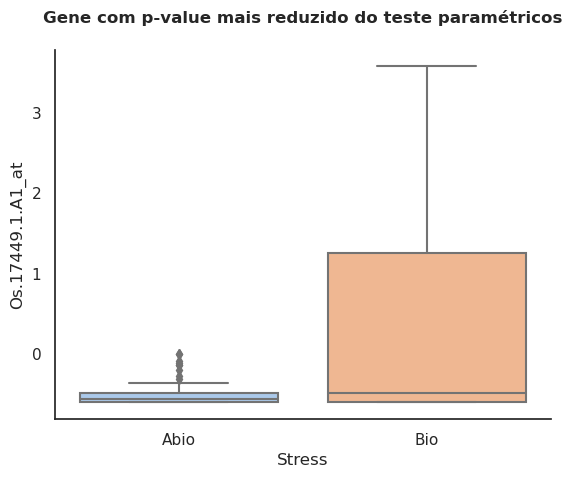

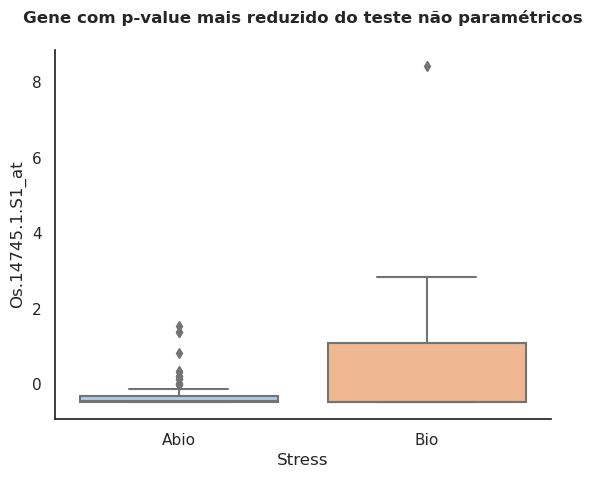

In [20]:
#Boxplots
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", palette="pastel", rc=custom_params)

#Boxplot gene c/ p-value mais baixo testes paramétricos
ax=sns.boxplot(y=z_min_col, x="Stress", data=df_std)
ax.set_title("Gene com p-value mais reduzido do teste paramétricos", y=1.05, fontweight='bold')
plt.show()

#Boxplot c/ p-value mais baixo dos testes não paramétricos
ax=sns.boxplot(y=mw_min_col, x="Stress", data=df_std)
ax.set_title("Gene com p-value mais reduzido do teste não paramétricos", y=1.05, fontweight='bold')
plt.show()

A sobreexpressão do gene **Os.17449.1.A1_at**, pertencente a família das auxinas, encontra-se associado a periodos de **ausência de azoto**, o que corresponde a um **stress abiótico**. Por sua vez o gene **Os.14745.1.S1_at** está associado ao processo fisiológico de **lenhificação**, e ocorrem alterações na sua expressão quando sujeito a **stresses bióticos**. Desta forma podemos concluir que usando a metodologia acima descritas foi possível **isolar** genes cuja expressão é **relevante** para a **distinção** entre stresses bióticos e abióticos.

De forma a visualizar graficamente as diferenças das variáveis face às classes estudadas, foram construídos 2 boxplots. O **primeiro** corresponde ao **gene** com o ***p-value*** **menor** entre os **testes paramétricos** e o **segundo** corresponde ao **gene** com o ***p-value*** **menor** entre os **testes não paramétricos**. Em ambos os casos é possível observar **diferenças** entre as **distribuições da variável** face às duas classes estudadas, **validando** os testes antes efetuados.

### Fase 2

## Análise Multivariada

### Análise de Correlações

Text(0.5, 1.05, 'Heatmap agrupado por genes correlacionados')

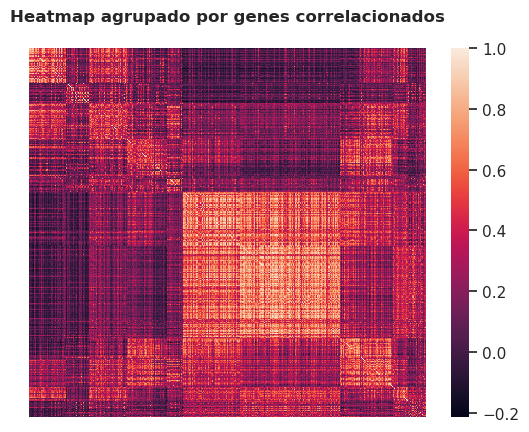

In [21]:
#Analise de correlaçoes

#Criar dataset standarizado sem variável independente
x = df_std.drop(df_std.columns[-1], axis=1)

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly
    correlated variables are next to eachother

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

sns.heatmap(cluster_corr(x.corr()), xticklabels=False, yticklabels=False).set_title("Heatmap agrupado por genes correlacionados", fontweight='bold', y=1.05)



Um **heatmap** agrupado foi gerado de formar uma **matrix de correlações** entre os genes, de forma a que genes **altamente correlacionados** sejam agrupados na matrix próximos uns dos outros. As labels dos genes foram omitidas para facilitar a interpretação dos resultados. É possível observar a ocorrência de **bastantes genes correlacionados**, quer diretamente ou inversamente. Os genes diretamente correlacionados encontram-se agrupados perto da hipotenusa do triângulo (diagonal do quadrado), enquanto que os inversamente correlacionados encontram-se agrupados junto do lado esquerdo do triângulo. Junto ao lado de baixo do triangulo encontram-se agrupados genes sem elevados valores de correlação entre si. Em suma, as elevadas correlações apresentadas demonstram a possibilidade de uma **eficaz redução da dimensionalidade deste dataset**.

### Redução de Dimensionalidade

#### Principal Component Analysis (PCA)

In [22]:
#PCA

#Inicializar o objeto PCA
pca = PCA(n_components=2)

pcomponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = pcomponents, columns = ["PC 1", "PC 2"], index = df_std.index)

#Adicionar variável independe a dataset com os componentes principais
final_pca_df = pd.concat([pca_df, df_std["Stress"]], axis=1)

In [23]:
final_pca_df

,PC 1,PC 2,Stress
info,,,
14-day-old seedling,-10.585646,-1.082805,Abio
"14-day-old seedling, heat shock",-9.579153,-0.428235,Abio
144hpi with array type rice from Affymetr,-20.258906,-4.932674,Bio
48hpia with array type rice from Affymetr,-20.274411,-4.953526,Bio
48hpib with array type rice from Affymetr,-20.278156,-4.959573,Bio
...,...,...,...
rice seedling grown under Pi-sufficient condition,13.705003,48.024431,Abio
temoin with array type rice from Affymetr,-20.253547,-4.934888,Bio
temoina with array type rice from Affymetr,-20.281120,-4.966821,Bio


Variação explicada pelos primeiros 5 componentes principais: [0.33024175 0.13415908 0.08662043 0.04844749 0.04086625]
Para explicar 95% da variância são necessários 39 compomentes.


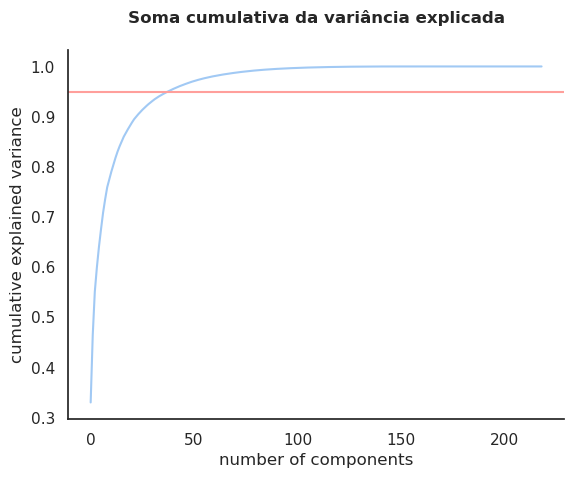

In [24]:
pca_d = PCA().fit(x)

pcomponents_d = pca_d.fit_transform(x)

#1º componente sumariza ~33%, 2ª componente sumariza ~13%, combinados ~47%
print('Variação explicada pelos primeiros 5 componentes principais: {}'.format(pca_d.explained_variance_ratio_[:5]))

count = 0
total_comp = 0
for comp in pca_d.explained_variance_ratio_:
    if total_comp <=0.95:
        total_comp += comp
        count += 1
print(f"Para explicar 95% da variância são necessários {count} compomentes.")

pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Soma cumulativa da variância explicada', fontweight='bold',  y=1.05)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')

O dataset que estamos a utilizar sofre a chamada "*Maldição da Dimensionalidade*", que é comum em dados ómicos de expressão. Esta característica implica um **número elevado de variáveis** (genes) associados a um **número pequeno de linhas** (amostras). Isto torna técnicas de redução de dimensionalidade sobre estes dados de particular importância para a interpretação e análise dos mesmos. A primeira técnica deste estilo por nós utilizada foi a ***Principal Component Analysis*** (**PCA**). Do dataset com **1377 variáveis** foram extraídos **2 componentes principais** que **cumulativamente explicam 47%** da **variação total** do dataset. De seguida, estes 2 componentes foram utilizados para representar as amostras num espaço bidimensional, para verificarmos se ocorre a separação dos dados nas duas classes em estudo.

Relativamente aos restantes componentes, construimos um gráfico para vizualizar a **acumulação da variância** do dataset com a retenção de um número **crescente** de variáveis. Concluimos que das **1377 variáveis iniciais**, conseguimos reduzir em **39** componentes principais que sumarizam **95%** da variância do dataset. Isto condiz com a análise de correlações efetuada, verificando-se a hipótese da **redução** da dimensionalidade deste dataset.

<Figure size 640x480 with 0 Axes>

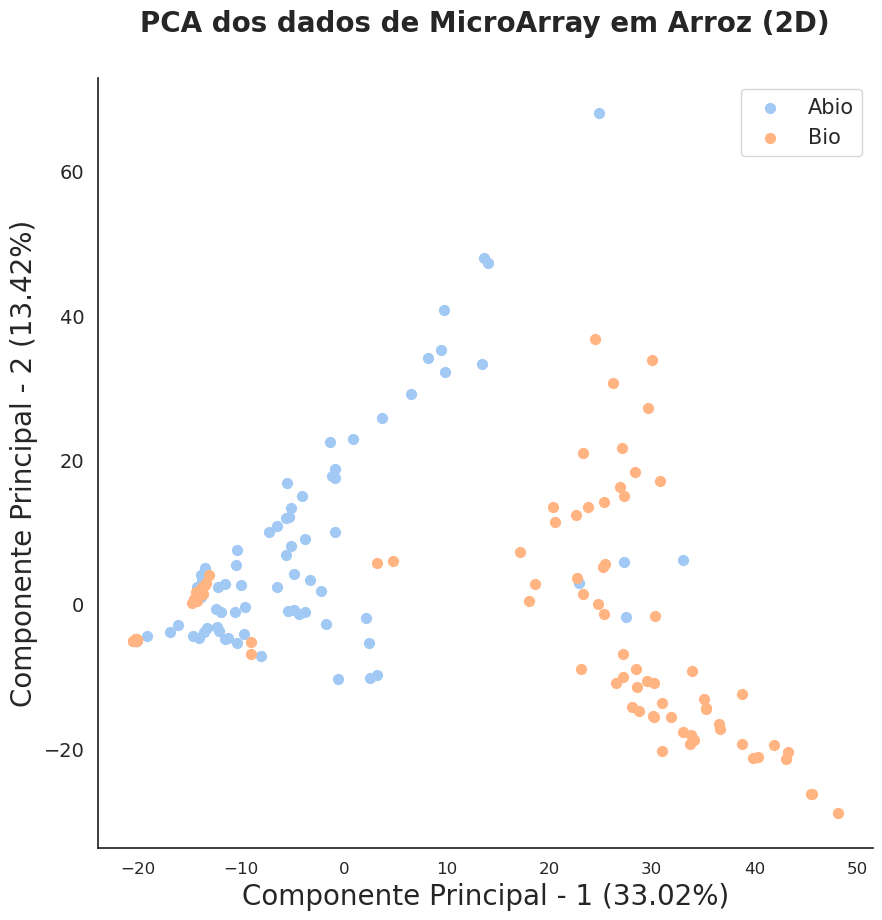

In [25]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Componente Principal - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)',fontsize=20)
plt.ylabel(f'Componente Principal - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)',fontsize=20)
plt.title("PCA dos dados de MicroArray em Arroz (2D)",y= 1.05, fontsize=20, fontweight='bold')
targets = ['Abio', 'Bio']
for target in targets:
    indicesToKeep = final_pca_df['Stress'] == target
    plt.scatter(final_pca_df.loc[indicesToKeep, 'PC 1']
               , final_pca_df.loc[indicesToKeep, 'PC 2'], s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

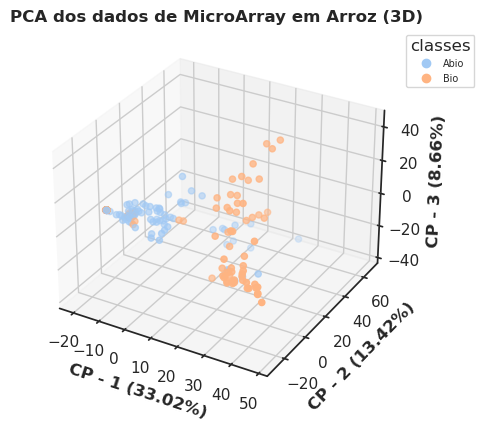

<Figure size 640x480 with 0 Axes>

In [26]:
#PCA 3D
pca = PCA(n_components=3)
x = df_std.drop(df_std.columns[-1], axis=1)
pcomponents = pca.fit_transform(x)
pca_df = pd.DataFrame(data = pcomponents, columns = ["PC 1", "PC 2", "PC 3"], index = df_std.index)

#Adicionar variável independe a dataset com os componentes principais
final_pca_df = pd.concat([pca_df, df_std["Stress"]], axis=1)

def pca_scatter_plot3d(x_pca, target, pca1=0, pca2=1, pca3=2, title=None, show=True):
        """
        Scatter plot of the labels based on three components (by default the first ones).
        Retrieves graphic showing the positions of labels according of the two chosen components
        :param title: string. title of the scatter plot
        :param target: labels of dataset
        :param pca1: first pca to be considered. default PCA1
        :param pca2: second pca to be considered. default PCA2
        :param pca3: third pca to be considered. default PCA3
        :param show: Whether to show the plot or no. True by default.
        :param path_save: Path to save the plot. pca_scatter_plot.png by default.
        :return: None
        """
        plt.clf()
        n_color = len(np.unique(target))
        # Get Unique ec
        color_labels = np.unique(target)
        # List of colors in the color palettes
        rgb_values = sns.color_palette("pastel", n_color)  # 'set2'
        # Map ec to the colors
        color_map = dict(zip(color_labels, rgb_values))
        # Finally use the mapped values
        from mpl_toolkits import mplot3d
        ax = plt.axes(projection="3d")
        ax.scatter3D(x_pca["PC 1"], x_pca["PC 2"], x_pca["PC 3"],
                     c=target.map(color_map))
        # create legend
        # classes  - colour labels
        # class_colours rgb values
        from matplotlib.lines import Line2D
        recs = []
        for i in range(0, n_color):
            recs.append(Line2D((0, 0.75), (0, 0), color=rgb_values[i], marker='o', linestyle=''))
            # recs.append(mpatches.Circle((0, 0), 0.5, fc=rgb_values[i]))
        n_col = int(n_color / 23) + 1
        lgd = plt.legend(recs, color_labels, bbox_to_anchor=(1, 1), loc="upper left",
                         fontsize='xx-small', ncol=n_col, shadow=False, title='classes')
        # add labels and title
        ax.set_xlabel(str(f'CP - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)'), fontweight='bold')
        ax.set_ylabel(str(f'CP - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)'), fontweight='bold')
        ax.set_zlabel(str(f'CP - 3 ({round(pca.explained_variance_ratio_[2]*100,2)}%)'), fontweight='bold')
        if title is None:
            title = "PCA dos dados de MicroArray em Arroz (3D)"
        plt.title(title,  fontweight='bold' )
        if show is True:
            plt.show()
        plt.clf()
        

pca_scatter_plot3d(x_pca=final_pca_df, target=final_pca_df["Stress"])


Após representação das amostras no mapa fatorial, observa-se uma **distinção** entre os **tipos de stress** ao **longo** do **eixo** do **primeiro componente**, que explica a maior fatia da variabilidade observada. Já ao longo do **segundo componente**, observa-se uma **dispersão das amostras**, não sendo este tão relevante para a separação das classes. É possível observar, contudo, que **uma porção** de **stresses bióticos** encontra-se **agrupada conjuntamente** com a vasta maioria dos **stresses abióticos** e o mesmo **se verifica**, em **menor grau**,  relativamente aos **stresses abióticos**. A adição de uma **terceira componente**, que explica ~ 9% da variância do dataset, permite uma mais clara **distinção dos stresses** entre si, ao longo do eixo dos z. No geral, observa-se uma **boa sepração** entre as classes em estudo.

#### Partial Least Squares - Discriminant Analysis (PLS-DA)

In [27]:
#PLS-DA

#Initialize PLS-DA
pls_da = PLSRegression(n_components=2, scale=False)

#Build dummy variable for the "Stress" variable
df_one = pd.get_dummies(df_std["Stress"])
df_two = pd.concat((df_one, df_std), axis=1)
df_two = df_two.drop(["Stress"], axis=1)
df_two = df_two.drop(["Abio"], axis=1)
result = df_two.rename(columns={"Bio": "Stress"})

#Fit the model to the data
pls_da = pls_da.fit(x.values, result["Stress"].values)

#Build dataset with PLS-DA results
pls_scores = pls_da.x_scores_
pls_scores = pd.DataFrame(pls_scores, columns=["C 1", "C 2"], index=final_pca_df.index)

#calcular o peso dos componentes
total_variance_in_x = np.var(x.values, axis = 0)
variance_in_x = np.var(pls_da.x_scores_, axis = 0)
fractions_of_explained_variance = variance_in_x / sum(total_variance_in_x)
print('Explained variation per component: {}'.format(fractions_of_explained_variance))

Explained variation per component: [0.20879221 0.13081812]


Outra técnica de redução de dimensionalidade usada foi a **PLS-DA**, por recomendação dos autores do estudo no qual este trabalho se inspira. Os **2 componentes** extraídos, **cumulativamente explicam** cerca de **34% da variância total** do dataset, sendo isto um **decréscimo** face ao observado no **PCA**.

<Figure size 640x480 with 0 Axes>

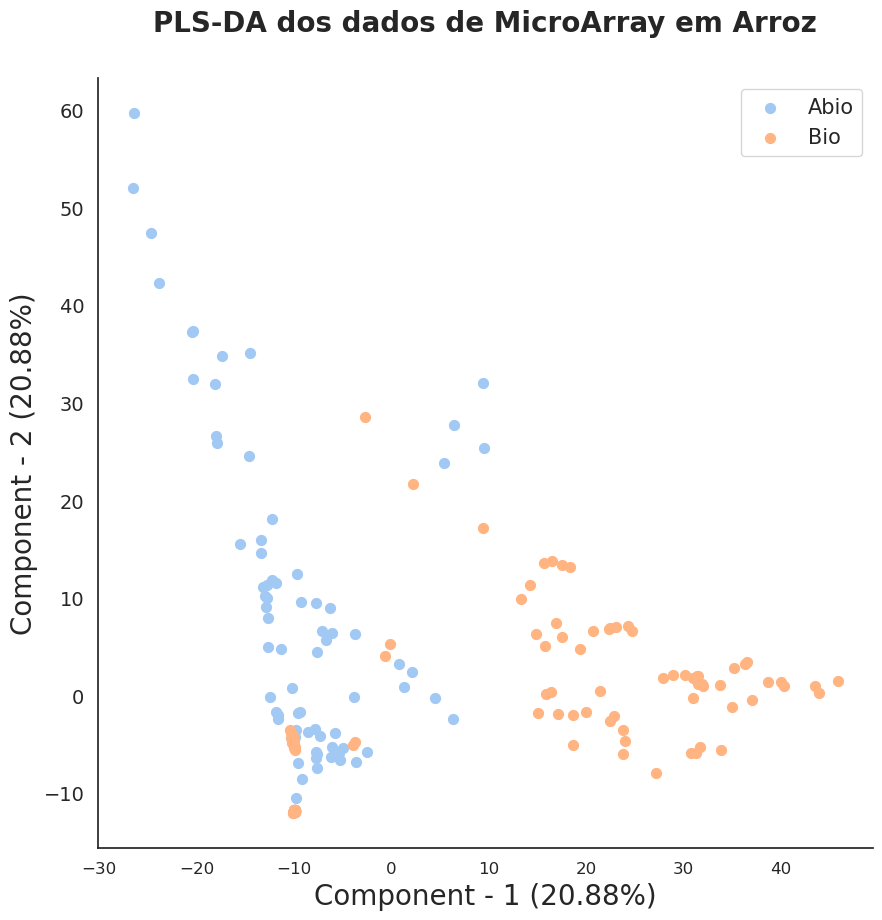

In [28]:
#Visualizar gráfico com resultado dos componentes

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Component - 1 ({round(fractions_of_explained_variance[0]*100, 2)}%)',fontsize=20)
plt.ylabel(f'Component - 2 ({round(fractions_of_explained_variance[0]*100, 2)}%)',fontsize=20)
plt.title("PLS-DA dos dados de MicroArray em Arroz",fontsize=20, y=1.05, fontweight='bold')
targets = ['Abio', 'Bio']

for target in targets:
    indicesToKeep = final_pca_df['Stress'] == target
    plt.scatter(pls_scores.loc[indicesToKeep, 'C 1']
               , pls_scores.loc[indicesToKeep, 'C 2'], s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()


À **semelhança** do **PCA**, observa-se uma **separação** das **classes** ao longo do **primeiro componente** e uma particular **dispersão** da **classe Abio** ao longo do **segundo componente**. Como observado acima, existe alguma **mistura entre** as **classes** com alguns **stresses** da **classe Bio agrupados** com os da **classe Abio** e vice-versa. No geral, apesar de apresentar uma menor percentagem total da variância do dataset no mapa fatorial, esta técnica **consegue separar** com uma **eficácia semelhante** ao **PCA** as duas classes entre si.

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

<Figure size 640x480 with 0 Axes>

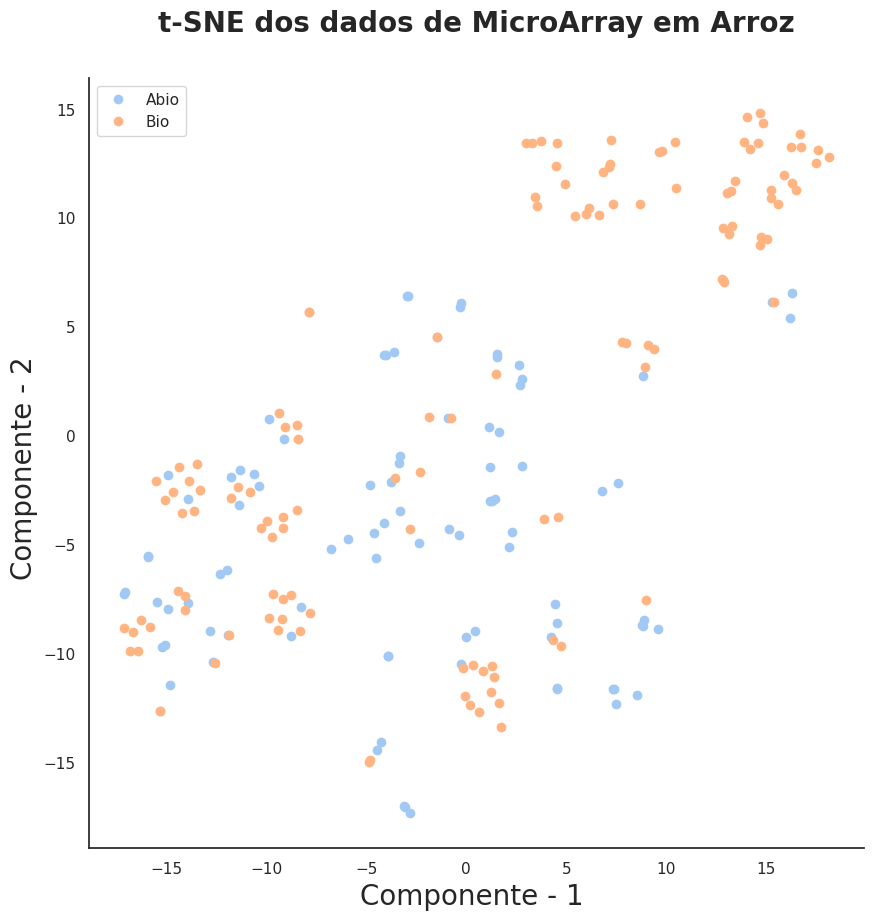

In [29]:
#t-SNE

#Initialize T-SNE
tsne = TSNE(n_components=2, n_iter=1000)

#Fit and transform the data
points = tsne.fit_transform(x.values)

#Prepare Index for plotting
df_std_ni = df_std.reset_index(drop=True)

plt.figure()
plt.figure(figsize=(10,10))

#Visualizar resultados T-SNE
for stress in df_std_ni['Stress'].unique():
    sp = df_std_ni.index[df_std_ni['Stress']==stress]-1
    plt.plot(points[sp,0], points[sp,1], 'o' , label=stress)
plt.title("t-SNE dos dados de MicroArray em Arroz", fontsize=20, y=1.05, fontweight='bold')
plt.xlabel(f'Componente - 1 ', fontsize=20)
plt.ylabel(f'Componente - 2 ', fontsize=20)
plt.legend(loc='best', shadow=False)
plt.show()

A última técnica de redução de dimensionalidade usada foi o **t-SNE**, tendo em conta a sua comprovada eficácia de classificação não supervisionada de grandes datasets. Após a técnica, observa-se que ocorre um **bom agrupamento** de **amostras** classificadas como **stresses bióticos** no **segundo quadrante** do gráfico, existindo, contudo, uma **fraca separação entre** as **classes** nos **restantes quadrantes**. No geral, achamos que esta técnica **não desempenhou tão bem** quanto as outras duas técnicas antes apresentadas, **podendo** isto **ser devido** ao **reduzido número de amostras** presente no dataset.

### Clustering

#### K-Means

In [30]:
# K-MEANS

#Inicializar K-Means
kmeans = KMeans(n_clusters = 2, random_state = 42, max_iter = 300, n_init = 10)
kmeans_f = kmeans.fit(x.values)

#Cross table com resultados dos clusters K-Means
labels = kmeans_f.labels_

print(pd.crosstab(labels, df_std["Stress"], rownames = ["clusters"]))


Stress    Abio  Bio
clusters           
0           13   60
1           78   68


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

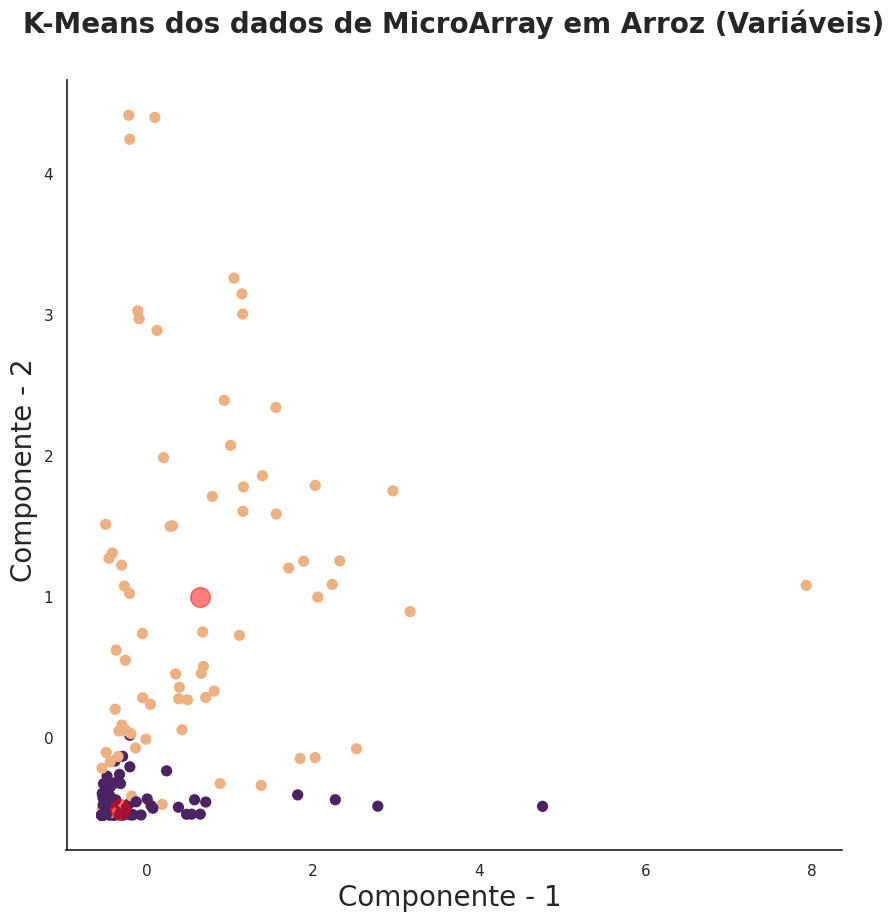

<Figure size 640x480 with 0 Axes>

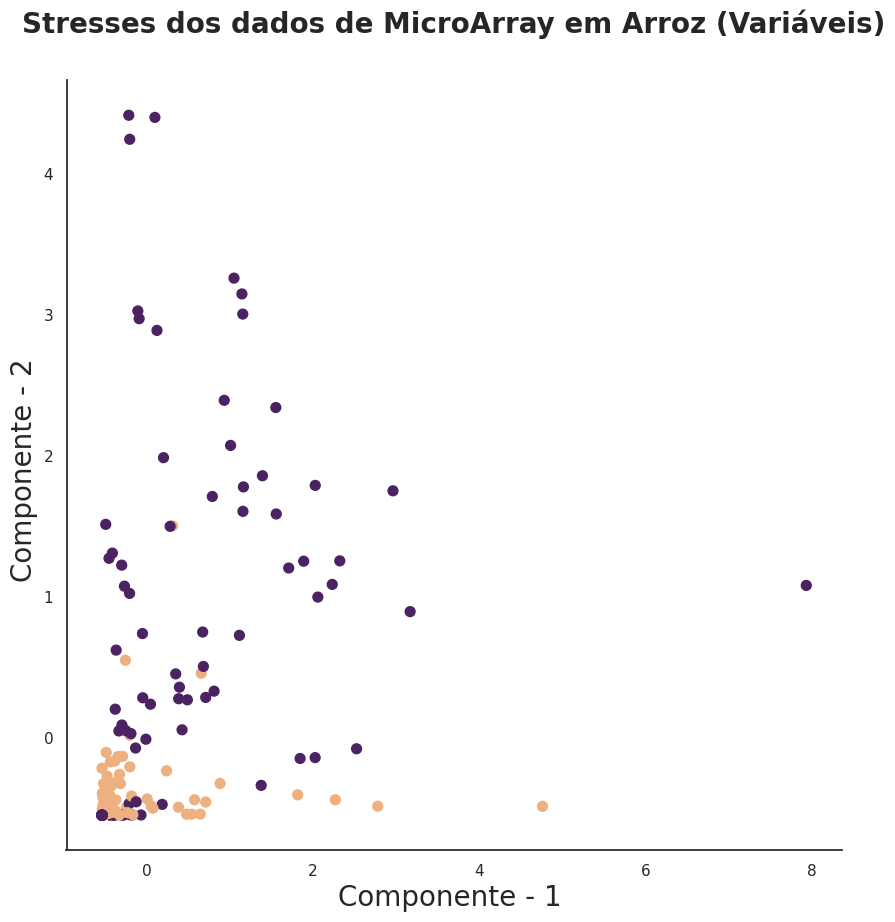

<Figure size 640x480 with 0 Axes>

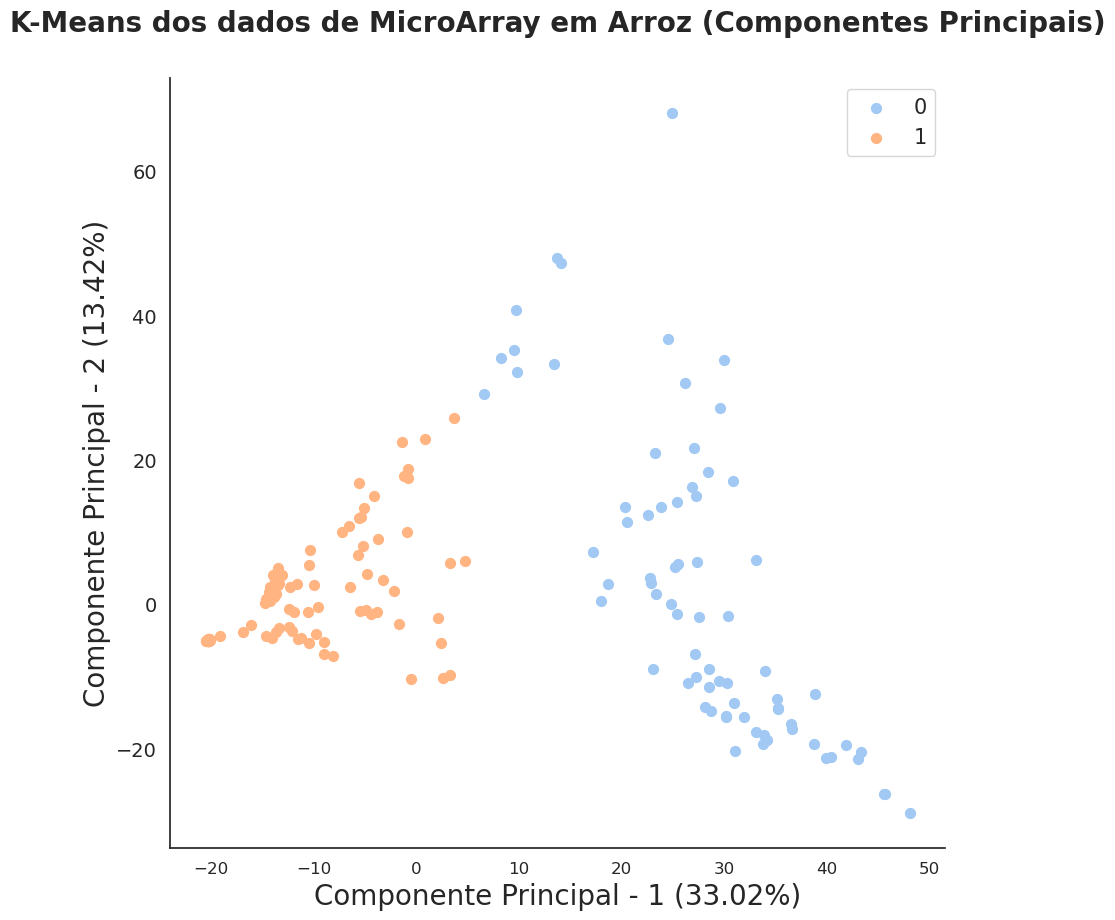

In [31]:
#Fazer previsão para obter atribuições dos clusters
y_pred_kmeans = kmeans_f.predict(x.values)

#Visulalizar resultado da atrivbuição dos grupos K-Means e clusters
plt.figure()
plt.figure(figsize=(10,10))
centers = kmeans_f.cluster_centers_
plt.figure()
plt.figure(figsize=(10,10))
plt.scatter(x.values[:, 0], x.values[:, 1], c=y_pred_kmeans, s=50, cmap="flare")
centers = kmeans_f.cluster_centers_
plt.title("K-Means dos dados de MicroArray em Arroz (Variáveis)", fontsize=20, y=1.05, fontweight='bold')
plt.xlabel(f'Componente - 1 ', fontsize=20)
plt.ylabel(f'Componente - 2 ', fontsize=20)
plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, alpha=0.5)
plt.show()

print()

#Visualizar atribuições reais dos grupos
plt.figure()
plt.figure(figsize=(10,10))
plt.scatter(x.values[:, 0], x.values[:, 1], c=result["Stress"].values, s=50, cmap="flare")
plt.title("Stresses dos dados de MicroArray em Arroz (Variáveis)",fontsize=20, y=1.05, fontweight='bold')
plt.xlabel(f'Componente - 1 ', fontsize=20)
plt.ylabel(f'Componente - 2 ', fontsize=20)
plt.show()

print()

#K-means PSA visualizaçao

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Componente Principal - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)',fontsize=20)
plt.ylabel(f'Componente Principal - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)',fontsize=20)
plt.title("K-Means dos dados de MicroArray em Arroz (Componentes Principais)",y= 1.05, fontsize=20, fontweight='bold')
targets = [0, 1]
for target in targets:
    indicesToKeep = y_pred_kmeans == target
    plt.scatter(final_pca_df.loc[indicesToKeep, 'PC 1']
               , final_pca_df.loc[indicesToKeep, 'PC 2'], s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

No seguimento das análises anteriores, tentamos aplicar **técnicas de classificação não supervisionada** de forma a **separar** as **amostras** pelas classes correspondentes ao **stress biótico** e **abiótico**. A primeria técnica que utilizamos foi a técnica do **K-Means**. Foi dado ao algoritmo o objetivo de criar 2 clusters, sendo esta uma tentativa de ver como o algoritmo se desempenhava na separação das amostras. Das **128** amostras correspondentes a **stress biótico** e das **91** correspondentes a **stress abiótico**, o algoritmo gerou **2 clusters**, sendo que um (**cluster 0**) classificou **maioritariamente** o **stress biótico** e algumas amostras como stress abiótico, e no outro (**cluster 1**) ocorre uma percentagem semelhante a **50%** entre **stress biótico** e **abiótico**, sendo que ocorreu um **ligeiro enriquecimento** na classificação de **stress abióticos**. No geral, observa-se um **moderado sucesso de classificação** das amostras através do algoritmo **K-Means**, particularmente afetando aquelas correspondentes ao **stress abiótico**.

Dos gráficos apresentados, o **primeiro** representa as **amostras** coloridas pela **classificação** do algoritmo **K-Means** , o **segundo** apresenta as **amostras** coloridas **de acordo com a sua classificação** entre **stress biótico** e **abiótico** e o **terceiro** apresenta as amostras coloridas pela **classificação** do algoritmo **K-Means**, mas projetadas nos primeiros **dois componentes principais** obtidos aquando do PCA realizado.

#### Clustering hierárquico

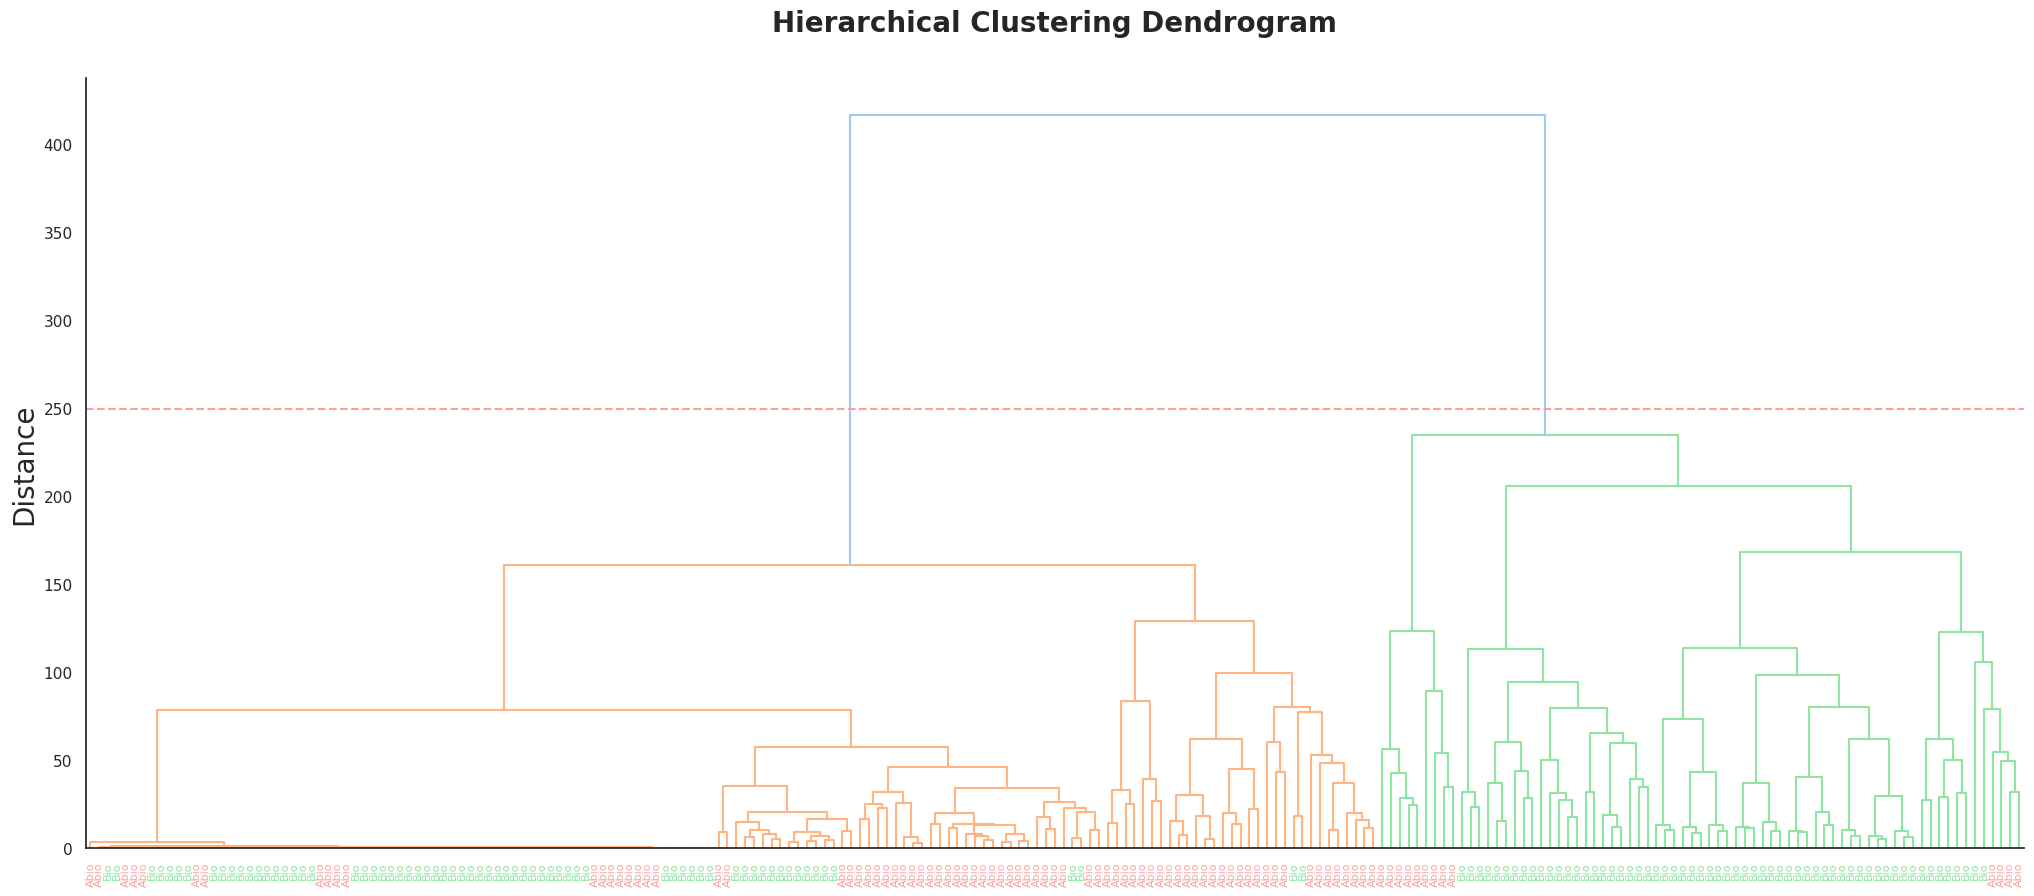

In [32]:
#Hierarchical clustering
#Construção e visualização do dendograma

#Correr algoritmo usando o método de Ward e distâncias euclideanas
Z = linkage(x.values, method='ward', metric='euclidean')

#Visualizar o Dendograma

plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_std.iloc[:,-1]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram', fontsize=20, y=1.05, fontweight='bold')
plt.ylabel('Distance', fontsize = 20)

# Assignment of colors to labels: 'a' is red, 'b' is green, etc.
label_colors = {'Abio': 'r', 'Bio': 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])
plt.axhline(y=250, color='r', linestyle='--')
plt.show()

A última técnica de **análise não supervisionada** efetuada sobre o dataset foi a de **clustering hierárquico**, do tipo **aglomerativo**.
A métrica utilizada foi a de **distância euclideana**, e o método usado foi o **método de** ***Ward***.

A observação do **dendograma** construído a partir do dataset revela-nos a existência de **2 grandes clusters** que se **separam logo no início da árvore**, podendo esta informação ser interpretada numa escala multi-dimensional. Observando as **folhas**, podemos concluir que o **cluster** que se apresenta **à direita**, a verde, congrega maioritariamente as amostras provenientes de **stresses bióticos**, enquanto que as amostras no cluster **à esquerda**, a laranja, agregam uma **mistura** entre **stress biótico** e **abiótico**.Contudo, apresenta **sub-clusters** em que os **stresses abióticos** se apresentam **agregados conjuntamente**.

In [33]:
#Clustering Hierárquico para classificação das amostras

#Inicializar o modelo
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

#Efetuar a previsão/atribuição dos clusters
cluster.fit_predict(x.values)

print(pd.crosstab(cluster.labels_, df_std["Stress"], rownames = ["clusters"]))


Stress    Abio  Bio
clusters           
0           13   60
1           78   68


<Figure size 640x480 with 0 Axes>

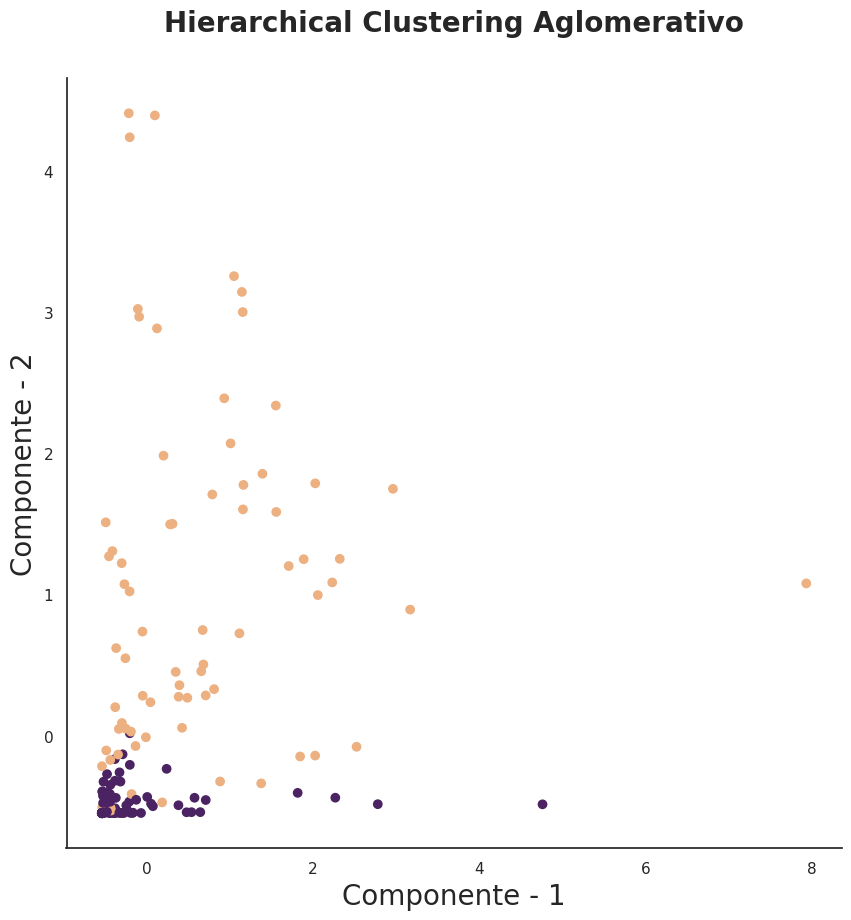

<Figure size 640x480 with 0 Axes>

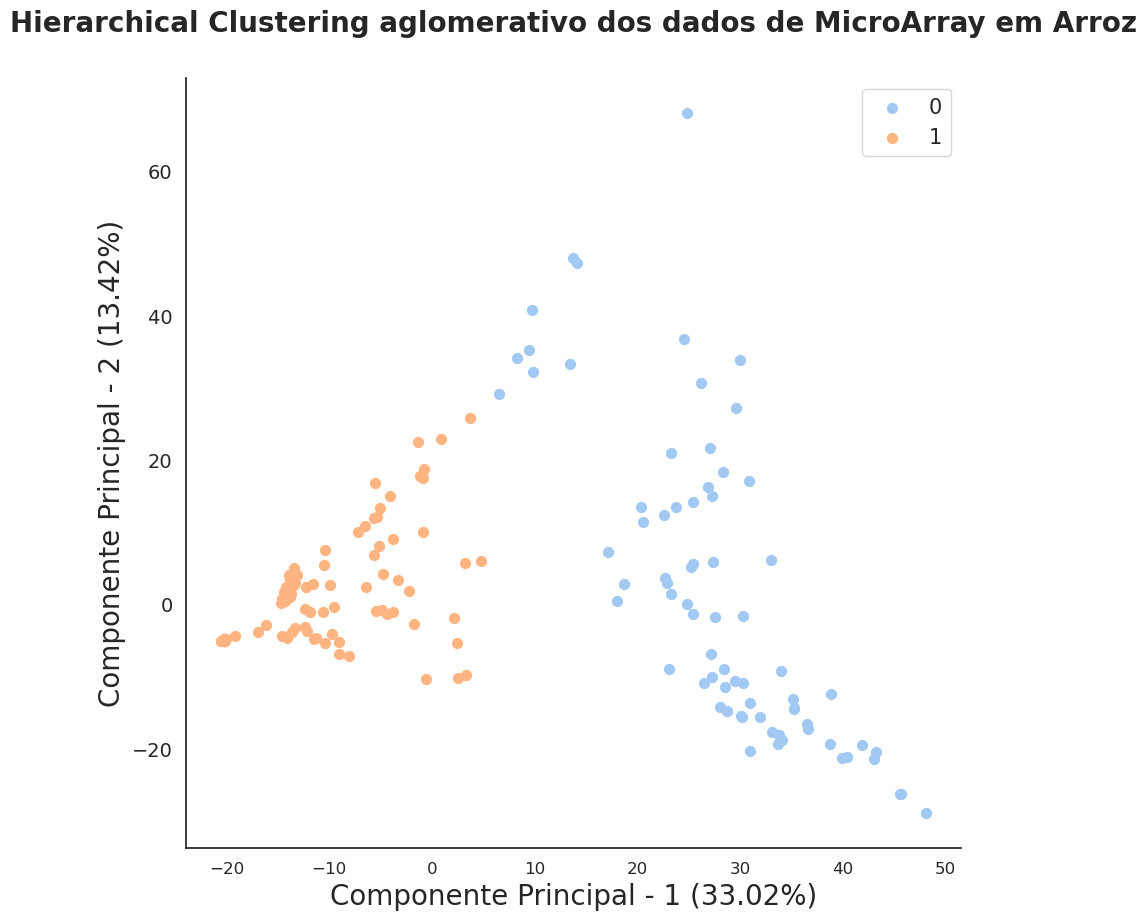

In [34]:
#Visualizar Clustering
plt.figure()
plt.figure(figsize=(10,10))
plt.scatter(x.values[:,0],x.values[:,1], c=cluster.labels_, cmap="flare")

plt.title('Hierarchical Clustering Aglomerativo', fontsize=20, y=1.05, fontweight='bold')
plt.ylabel('Componente - 2', fontsize=20)
plt.xlabel('Componente - 1', fontsize=20)
plt.show()


plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(f'Componente Principal - 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)',fontsize=20)
plt.ylabel(f'Componente Principal - 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)',fontsize=20)
plt.title("Hierarchical Clustering aglomerativo dos dados de MicroArray em Arroz",y= 1.05, fontsize=20, fontweight='bold')
targets = [0, 1]
for target in targets:
    indicesToKeep = cluster.labels_ == target
    plt.scatter(final_pca_df.loc[indicesToKeep, 'PC 1']
               , final_pca_df.loc[indicesToKeep, 'PC 2'], s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

Após a análise do dendograma, um **clustering hiérarquico** para **2 clusters** foi aplicado ao dataset e utilizado para obter as **atribuições** de **cada amostra** a **cada um dos cluster**. Esta informação está representada graficamente no mapa fatorial acima, apresentando as amostras uma distribuição semelhante à observada aquando da análise **K-Means**. Isto é ainda mais evidente quando as amostras são projetadas nos primeiros **dois componentes principais** provenientes do PCA realizado, apresentando a **mesma classificação** do algoritmo K-Means.

## Sumário

A partir da análise dos resultados até aqui obtidos, podemos **provisoriamente concluir** que apesar da ocorrência de **variáveis que não auxiliam na distinção** entre **stress biótico** e **abiótico**, as **análises não supervisionadas** demonstram uma **separação** entre estas **duas classes**, **particularmente** para as amostras provenientes de **stresse biótico**. Esperamos agora que utilizando as análises supervisionadas, consigamos treinar um modelo capaz de **classificar corretamente** a amostra como proveniente de **stress biótico** ou **abiótico**, a partir dos **dados** de **expressão genética em microaarays** para o conjunto de genes do dataset.

### Fase 3

# Análise Supervisionada

Após efetuarmos a análise **univariada** e **não supervisionada** com o dataset à nossa disposição, propusemo-nos a criar um modelo de **Machine Learning** que a partir de um dado conjunto de dados de **expressão genética** (microarrays) fosse capaz de corretamente prever se a planta tinha sido exposta a **stresses** bióticps ou abióticos. Desta forma, apresentamos de seguida a nossa pipeline para a análise **supervisionada**.

## Importação do Dataset

Para inicializar a parte de ***Machine Learning*** (**ML**), primeiramente carregamos um cvs (**Final_ds.csv**) contendo o dataset utilizado na fase anterior. No entanto nesta fase foi necessário proceder à **binarização** da **variável Stress**, afim de ser possível calcular as métricas para cada um dos modelos de ML por nós realizados. Desta forma atribuímos o valor de **1** à categoria **Bio** e **0** à categoria **Abio**.

In [35]:
#Re_Importing Dataset
df = pd.read_csv("Final_ds.csv")

#Binarização das variáveis
df["Stress"] = df["Stress"].replace({"Bio": 1, "Abio": 0})

#Setting X (features) and y (labels)
X = df.iloc[:, 1:-1].values
y = df["Stress"].values

## Preparação da análise

Numa primeira fase iremos proceder ao treino e avaliação de modelos de **ML** sem efetuar uma ***Feature Selection***. De notar que os nosso dados **não permitem** a realização de **modelos de regressão**, razão pela qual apenas **utilizamos modelos de classificação**. Uma vez que apenas temos duas classes aos quais os nossos dados podem ser atribuídos, as nossas **classificações** são do tipo **binário**.
De forma a facilitar o processo de treino dos modelos de **ML** criamos a função abaixo que permite ter uma ideia inícial de como o modelo se irá comportar, através da avaliação por ***Cross Validation*** (**CV**), assim como o seu real comportamento aquando do treino e previsão dos modelos.
A avaliação dos modelos será feita tendo por base as métricas **accuracy**, **recall**, **precision**, **F1 score** e **ROC AUC**.

- **balanced_acuracy**: calcula a accuracy de um subconjunto, isto é, é definida como a média de cada recall obtida em cada classe. o melhor valor é 1 e o pior é 0 quando adjusted = False.

- **recall**: corresponde ao rácio tp / (tp + fp), onde tp representa o número de verdadeiros positivos e fp o número de falsos positivos. o recall desempenha a capacidade de classificador responsável por encontrar todas as amostras positivas.

- **precision**: corresponde ao rácio tp / (tp + fp), onde tp representa o número de verdadeiros positivos e fp o número de falsos positivos. a precisão desempenha o papel de classificador de modo a não rotular uma amostra positiva como uma amostra negativa. varia entre 0 (pior pontuação) e 1 (melhor pontuação).

- **f1_weighted**: média da precisão e do recall e varia de 0 (pior pontuação) a 1 (melhor pontuação). É calculado através da expressão: F1 = 2 * (precision * recall) / (precision + recall)

- **roc_auto**: calcula a área sob a curva de característica de operação do receptor através de scores preditivos.

In [36]:
def run_ml_algorithms(models, x_train, y_train, x_test, y_test, cv,indexes, filename):

    ## cv evaluation before training
    # metrics
    cv_acc = []
    cv_recall = []
    cv_prec = []
    cv_f1 = []
    cv_roc_auc = []

    for model in models:
        # print(f"cv {model}")
        cv_acc.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='balanced_accuracy', n_jobs=-1)))
        cv_recall.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='recall', n_jobs=-1)))
        cv_prec.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='precision', n_jobs=-1)))
        cv_f1.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)))
        cv_roc_auc.append(mean(cross_val_score(estimator=model, X=x_train, y=y_train, cv=cv, scoring='roc_auc', n_jobs=-1)))

    ##ML train
    ml_acc = []
    ml_recall = []
    ml_prec = []
    ml_f1 = []
    ml_roc_auc = []

    for model in models:
        # print(f"ML {model}")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        ml_acc.append(accuracy_score(y_test, y_pred))
        ml_recall.append(recall_score(y_test, y_pred, average='binary', pos_label=1))  # ability to find all positive samples
        ml_prec.append(precision_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0))
        ml_f1.append(f1_score(y_test, y_pred, average='binary', pos_label=1))  # relevant label F1-score
        ml_roc_auc.append(roc_auc_score(y_test, y_pred))

    total_dict = {"Accuracy CV": [acc for acc in cv_acc], "Recall CV": [rc for rc in cv_recall],"Precision CV": [prec for prec in cv_prec],
                  "F1 score CV": [f1 for f1 in cv_f1], "ROC AUC CV": [roc for roc in cv_roc_auc], "Accuracy ML": [acc for acc in ml_acc], "Recall ML": [rc for rc in ml_recall],
                  "Precision ML": [prec for prec in ml_prec], "F1 score ML": [f1 for f1 in ml_f1], "ROC AUC ML": [roc for roc in ml_roc_auc]}

    df_total = pd.DataFrame.from_dict(total_dict)
    df_total = df_total.set_index(model for model in indexes)
    df_total.to_csv(filename)

    return df_total

De forma a realizar **ML**, o dataset standarizado foi dividido no conjunto das **features**, que correspondem as variáveis utilizadas no treino do modelo, e na variável que desejamos classificar (**label**). Estes dois datasets foram então divididos num conjunto de **treino** e um conjunto de **teste**, tendo estes uma alocação de 70% e 30% dos dados originais, respetivamente.

Para nos auxiliar a verificar qual o melhor modelo de **ML**, utilizamos **validação cruzada**, mais concretamente Repeated **k-fold Cross-Validation**, utilizando 3 repetições e 10 folds por cada repetição.

A **reproducibilidade** dos resultados foi assegurada através da definição de uma **random seed**, que foi utilizada nos parâmetros random state, das restantes funções utilizadas.

In [37]:
#Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Validação cruzada
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#Setting up random State
rand_seed = 1735038

Para efetuar **ML** utilizando o nosso dataset, deparamo-nos com um problema de classificação **binário**. Deste modo, foram selecionados e testados modelos de **ML**, que fossem capazes de efetuar esta análise. Foram testados um total de **9 modelos**, correspondento estes a ***Logistic Regression***, ***Naive-Bayes***, **k-Nearest Neighbor (KNN)**, ***Decision Tree***, ***Random Forest***, ***Support Vector Classification***, **Neural Network Multi-layer Perceptron (MLP)**, ***Bagging Classifier usando Random Forest*** e ***AdaBoost***.

No modelo de regressão logística e MLP foram definidos um máximo de **1000 iterações**. No modelo KNN este foi parametrizado para utilizar **2 vizinhos**. Por último os modelos Decision Tree, Random Forest e Bagging Classifier tomam como parâmetro a ***random seed*** atrás definida de modo a assegurar a sua reproducibilidade.

In [38]:
#ML models
lgr = LogisticRegression(max_iter=1000, n_jobs=-1)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
dt = DecisionTreeClassifier(random_state=rand_seed)
rf = RandomForestClassifier(n_jobs=-1, random_state=rand_seed)
svc = SVC()
mlp = MLPClassifier(max_iter=1000)
bc_rf = BaggingClassifier(RandomForestClassifier(n_jobs=-1, random_state=rand_seed))
ada = AdaBoostClassifier()

models = [lgr, gnb, knn, dt, rf, svc, mlp, bc_rf, ada]
models_index = ["Logistic Regression", "Naive-Bayes", "KNN", "Decision Tree", "Random Forest", "SVM", "Neural Networks", "Bagging Classifier RF", "Ada Boost Classifier"]

## Machine Learning

### Sem Feature Selection

Após definir os modelos, utilizamos a função ***run_ml_algorithms*** para os correr e avaliar, comparando os resultados da validação cruzada com uma única instância de ML. Tanto para a ***validação cruzada*** como para o **ML** foi utilizado o output da função ***train_test_split***.

A secção final da função ***run_ml_algorithms*** agrega as métricas sobre um único dataset, que serve como suporte para a sua ***comparação***. Nesta abordagem inicial utilizamos os dataset completos para efetuar os treinos.

In [39]:
Metrics_no_FS = run_ml_algorithms(models=models, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, cv=cv, indexes=models_index, filename = "Metric_no_FS.csv")

Metrics_no_FS

,Accuracy CV,Recall CV,Precision CV,F1 score CV,ROC AUC CV,Accuracy ML,Recall ML,Precision ML,F1 score ML,ROC AUC ML
Logistic Regression,0.883246,0.963832,0.868883,0.890339,0.968980,0.893939,1.000000,0.857143,0.923077,0.854167
Naive-Bayes,0.670662,0.467581,0.842103,0.626764,0.760966,0.681818,0.500000,1.000000,0.666667,0.750000
KNN,0.943807,0.923858,0.972538,0.939820,0.952071,0.939394,0.952381,0.952381,0.952381,0.934524
Decision Tree,0.808137,0.822664,0.840625,0.807314,0.808137,0.909091,0.952381,0.909091,0.930233,0.892857
Random Forest,0.924548,0.933555,0.937168,0.923711,0.988606,0.969697,1.000000,0.954545,0.976744,0.958333
SVM,0.814642,0.951347,0.802073,0.819412,0.849020,0.878788,1.000000,0.840000,0.913043,0.833333
Neural Networks,0.886956,0.967088,0.869272,0.889644,0.958747,0.893939,1.000000,0.857143,0.923077,0.854167
Bagging Classifier RF,0.909436,0.933555,0.924256,0.910508,0.978924,0.924242,0.976190,0.911111,0.942529,0.904762
Ada Boost Classifier,0.935085,0.960051,0.940316,0.938710,0.985937,0.954545,0.976190,0.953488,0.964706,0.946429


<AxesSubplot:title={'center':'$\\it{Machine}$ ${Learning}$'}>

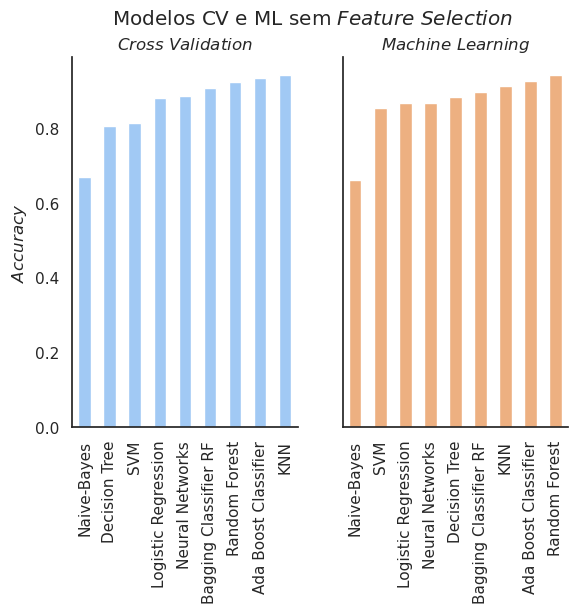

In [40]:
"""
Plot for accuracy of CV and ML without feature selection
"""


fig, axes = plt.subplots(1, 2)
fig.suptitle('Modelos CV e ML sem $\it{Feature}$ $\it{Selection}$')

axes[0].set_title('$\it{Cross}$ ${Validation}$')
axes[1].set_title('$\it{Machine}$ ${Learning}$')

for ax in axes.flat:
    ax.set(ylabel='$\it{Accuracy}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

Metrics_no_FS.sort_values('Accuracy CV', inplace=True)

Metrics_no_FS.plot(y='Accuracy CV', kind='bar', legend=False, ax=axes[0])

Metrics_no_FS.sort_values('Accuracy ML', inplace=True)

Metrics_no_FS.plot(y='Accuracy ML', kind='bar', legend=False, ax=axes[1], cmap='flare')

Analisando a ***accuracy*** dos modelos avaliados, verificamos que em ambos os cenários apresentados o modelo ***Naive-Bayes*** é o modelo com a accuracy **mais baixa**, rondando os 70%. Já quanto aos melhores modelos, verificamos que, a nível de ***accuracy***, os três melhores modelos no cenário de **validação cruzada** são ***Random Forest*** (92,45%), ***AdaBoost*** (93,51%) e ***KNN*** (94,38%). Já no cenário de ***Machine Learning*** temos que os três melhores modelos passam a ser ***KNN*** (93,9%), ***AdaBoost*** (95,4%) e ***Random Forest*** (96,97%). Comparando os dois cenários, a nível de ***accuracy***, o melhor modelo no cenário de ***CV***, ***KNN***, tem uma accuracy ligeiramente inferior ao melhor modelo do cenário ***ML***, ***Random Forest***. Isto pode ser devido a ***Random Seed*** definida que pode tender o modelo para um cenário de otimalidade numa primeira iteração.

### Feature Selection

Numa segunda instância decidimos proceder ao processo de ***Feature Setection***, afim de ver se uma seleção de *features* traría alguma melhoria aos nossos modelos ou se com um número mais reduzido de *features* conseguiríamos resultados semelhantes aos conseguidos com o dataset completo. Para a realização da ***Feature Selction*** slecionamos o métodos ***SlecktKBest*** com a **função de** ***score*** ***f_classif*** , tendo nós optado por selecionar 600 features do dataset.

In [41]:
#feature selction
X_features = SelectKBest(score_func=f_classif, k=600).fit_transform(X,y)

#Train_Test_Split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_features, y, test_size=0.3, random_state=0)

In [42]:
Metrics_FS = run_ml_algorithms(models=models, x_train=X_train_f, y_train=y_train_f, x_test=X_test_f, y_test=y_test_f, cv=cv, indexes=models_index, filename = "Metric_FS.csv")

Metrics_FS

,Accuracy CV,Recall CV,Precision CV,F1 score CV,ROC AUC CV,Accuracy ML,Recall ML,Precision ML,F1 score ML,ROC AUC ML
Logistic Regression,0.872736,0.968131,0.854362,0.880861,0.945976,0.893939,1.000000,0.857143,0.923077,0.854167
Naive-Bayes,0.685311,0.475451,0.863413,0.639870,0.778798,0.681818,0.500000,1.000000,0.666667,0.750000
KNN,0.952557,0.933487,0.983241,0.950563,0.959175,0.909091,0.928571,0.928571,0.928571,0.901786
Decision Tree,0.828462,0.853604,0.850470,0.827043,0.828462,0.924242,0.976190,0.911111,0.942529,0.904762
Random Forest,0.929773,0.937721,0.946122,0.930385,0.986282,0.954545,1.000000,0.933333,0.965517,0.937500
SVM,0.817115,0.944983,0.803689,0.821755,0.861512,0.878788,1.000000,0.840000,0.913043,0.833333
Neural Networks,0.884701,0.972298,0.867278,0.891469,0.947459,0.893939,1.000000,0.857143,0.923077,0.854167
Bagging Classifier RF,0.908212,0.933555,0.918820,0.908340,0.978560,0.924242,0.976190,0.911111,0.942529,0.904762
Ada Boost Classifier,0.926400,0.941358,0.940314,0.930568,0.979036,0.939394,0.952381,0.952381,0.952381,0.934524


<AxesSubplot:title={'center':'$\\it{Machine Learning}$'}>

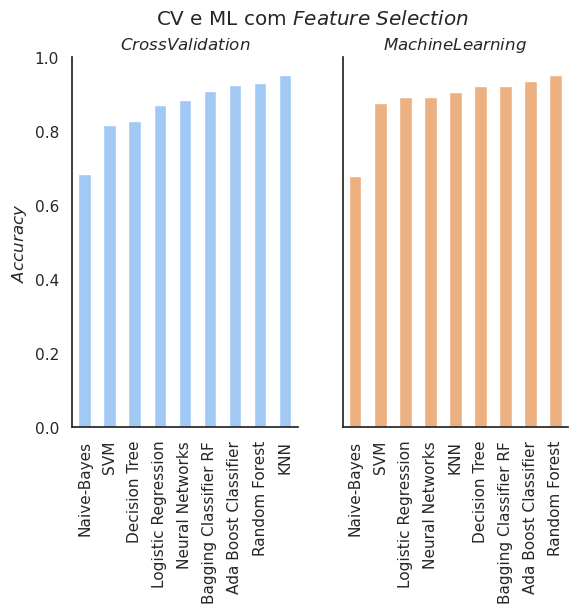

In [43]:
"""
Plot for accuracy of CV and ML with Feature Selection
"""


fig, axes = plt.subplots(1, 2)
fig.suptitle('CV e ML com $\it{Feature}$ $\it{Selection}$')

axes[0].set_title('$\it{Cross Validation}$')
axes[1].set_title('$\it{Machine Learning}$')

for ax in axes.flat:
    ax.set(ylabel='$\it{Accuracy}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

Metrics_FS.sort_values('Accuracy CV', inplace=True)

Metrics_FS.plot(y='Accuracy CV', kind='bar', legend=False, ax=axes[0])

Metrics_FS.sort_values('Accuracy ML', inplace=True)

Metrics_FS.plot(y='Accuracy ML', kind='bar', legend=False, ax=axes[1], cmap='flare')

Avaliando agora os resultados da accuracy nos dois cenários após efetuarmos ***Feature Selection*** temos que os resultados se aparentam semelhantes aqueles obtidos utilizando todas as features. Em ambos os cenários o modelo com a pior accuracy permanece o modelo ***Naive-Bayes***, com valores de 68,53% no cenário ***CV*** e 68,18% no cenário ***ML***.

Já comparando as ***accuracys dos 3 melhores modelos nos dois cenários, encontramos algumas diferenças. No cenário ***CV*** os três melhores modelos correspondem ao ***AdaBoost*** (92,64%), ***Random Forest*** (92,98%) e ***KNN*** (96,97%). Já no cenário ***ML*** estes correspondem ao ***Bagging Classifier*** (93,94%), ***AdaBoost*** (93,94%) e ***Random Forest*** (95,45%).

Maiores alterações ocorrem ao nível do cenário ***ML***, ***KNN*** é suplantado por ***Bagging Classifier***, melhor accuracy do cenário ***CV*** é agora superior a melhor do cenário ***ML***. Ambos os valores são inferiores as melhores accuracies sem ***Feature Selection***.

No geral, observamos que as maiores alterações face a análise anterior ocorrem ao nível do cenário ***ML***. Primeiro, a posição do modelo ***KNN*** no top 3 é tomada pelo modelo ***Bagging Classifier***. Seguidamente, verrifica-se que a melhor ***accuracy*** do cenário ***CV*** é agora superior à melhor do cenário ***ML***. Por último, verificamos que os melhores valores de ***accuracy*** em cada um dos cenários com ***feature selection*** é inferior aos seus respetivos sem ***feature selection***.

## Otimização de Hiperparâmetros

Das análises anteriores verificamos que o modelo ***KNN*** e o modelo ***Random Forest*** foram aqueles que obtiveram melhores valores de ***accuracy*** nos cenários de ***CV*** e ***ML*** respetivamente. Dessa forma, estes dois modelos foram selecionados para serem sujeitos a uma **otimização de hiperparâmetros** de modo a verificar qual dos dois modelos efetivamente possuiu **melhores métricas** face a classificação do stress biótico e abiótico.

Por causa dos melhores valores de ***accuracy*** que foram obtidos na ausência de ***Feature Selection***, este foi o modo ***default*** de treino dos modelos daqui em diante. Para a otimização em si foi optada uma otimização do tipo ***Grid Search***, tendo sido definida um conjunto de parâmetros a testar para cada um dos modelos.


In [44]:
#Hyperparameter Optimization

#Função de avaliação
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = 100 * accuracy_score(y_test,y_pred)
    print('Model Performance')
    print('Accuracy = {:0.2f}%. \n'.format(accuracy))
    return accuracy

### Random Forest

Para otimizar os hiperparâmetros no modelo ***Random Forest***, foi primeiro consultado a lista de **todos os parâmetros** utilizados por **definição** no algoritmo.

In [45]:
# Create a base model
rf = RandomForestClassifier(n_jobs=-1, random_state=rand_seed)

#Get Parameters
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

rf = rf.fit(X_train, y_train)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1735038,
 'verbose': 0,
 'warm_start': False}


Após consulta da **bibliografia**, foram selecionados **6 parâmetros** para serem otimizados, correspondendo estes ao ***Bootstrap***, ***max_depth***, ***max_features***, ***min_sample_leaf***, ***min_sample_split*** e ***n_estimators***. Estes parâmetros são aqueles que têm um maior impacto na capacidade de classificação do modelo, sendo que a metodologia ***GridSearch*** irá testar exaustivamente todas as combinações possíveis entre eles e devolver aquela com os melhores parâmetros.

In [46]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, None],
    'max_features': [2, 3, "auto"],
    'min_samples_leaf': [1, 3, 4],
    'min_samples_split': [1, 2, 4, 8, 10],
    'n_estimators': [80, 100, 200, 300, 1000]}

A ***Grid Search*** foi efetuada usando **3 validações cruzadas**.

In [47]:
tic = time()

# Instantiate the grid search model
grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=rand_seed), param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

gs_time = time() - tic
print(f"O Grid search demorou {gs_time} segundos \n")

print(f"Melhores parâmetros após a otimização de hiperparâmetros: \n {grid_search.best_params_}")

O Grid search demorou 83.96923327445984 segundos 

Melhores parâmetros após a otimização de hiperparâmetros: 
 {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


Efetuada a ***Grid Search***, foi nos devolvido a **melhor combinação** de hiperparâmetros dentro dos testados após a **otimização** dos mesmos.

In [48]:
print("Base Model")
base_accuracy = evaluate(rf, X_test, y_test)

print("Grid Search Model")
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 96.97%. 

Grid Search Model
Model Performance
Accuracy = 96.97%. 

Improvement of 0.00%.


De seguida, o modelo obtido da **otimização de hiperparâmetros** foi testado, avaliando a sua ***accuracy*** quando comparada com a accuracy de um modelo ***Random Forest*** com parâmetros **default**.

Verifica-se que não ocorre uma **melhoria do performance** do modelo após a otimização de hiperparâmetros, mantendo-se a 96,97%. Desta forma podemos concluir que, com base no conjunto de hiperparâmetros testado, o modelo já **atingiu** com os parâmetros ***default*** a ***accuracy máxima*** possível de acordo com os parâmetros procurados.

### KNN

Para otimizar os **hiperparâmetros** no modelo ***KNN***, foi primeiro consultado a lista de todos os parâmetros utilizados por **definição** no algoritmo.

In [49]:
# Create a base model
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

# Look at parameters used by our current KNN
print('Parameters currently in use:\n')
pprint(knn.get_params())

knn = knn.fit(X_train, y_train)

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}


Após consulta da **bibliografia**, foram selecionados **6 parâmetros** para serem otimizados, correspondendo estes ao ***algorithm***, ***n_neighbors***, ***leaf_size***, ***weights***, ***metric*** e ***p***. Estes parâmetros são aqueles que têm um maior impacto na capacidade de **classificação** do modelo, sendo que a metodologia ***GridSearch*** irá testar exaustivamente todas as **combinações** possíveis entre eles e devolver aquela com os **melhores parâmetros**.

In [50]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]

grid_params = {"algorithm" : algorithm,'n_neighbors': n_neighbors, "leaf_size": leaf_size,
               'weights': ['uniform','distance'],
               'metric': ['minkowski','euclidean','manhattan'],
                "p": p}

In [51]:
t=time()

# Instantiate the grid search model
gs = GridSearchCV(KNeighborsClassifier(n_jobs=-1), grid_params, verbose=0, cv=3, n_jobs=-1)

gs_res = gs.fit(X_train, y_train)

gs_t = time() - t
print(f"O Grid search demorou {gs_t} segundos \n")

print(f"Melhores parâmetros após a otimização de hiperparâmetros: \n {gs_res.best_params_}")

O Grid search demorou 1187.8473358154297 segundos 

Melhores parâmetros após a otimização de hiperparâmetros: 
 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


Efetuada a ***Grid Search***, é nos devolvida a melhor combinação de **hiperparâmetros** dentro das testadas após a **otimização** dos mesmos.

In [52]:
print("Base Model")
base_accuracy = evaluate(knn, X_test, y_test)

print("Grid Search Model")
best_gs = gs_res.best_estimator_
random_accuracy = evaluate(best_gs, X_test, y_test)

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model
Model Performance
Accuracy = 93.94%. 

Grid Search Model
Model Performance
Accuracy = 96.97%. 

Improvement of 3.23%.


De seguida, o modelo obtida da **otimização** de **hiperparâmetros** foi testado, avaliando a sua ***accuracy*** quando comparada com a ***accuracy*** de um modelo ***KNN*** com parâmetros ***default***.

Após a **otimização** de **hiperparâmetros** verificou-se que ocorreu uma **melhoria** de **3,23%** na ***accuracy*** do modelo com os **hiperparâmetros otimizados**, face ao modelo base. Desta forma, o modelo ***KNN*** atingiu uma accuracy de **96,97%**, que corresponde a accuracy antes obtida no modelo ***Random Forest***. Estes resultam suportam a nossa conclusão anterior, podendo ser o valor de ***accuracy máximo*** possível com o nosso dataset.

## Comparação de modelos

Após a **otimização de hiperparâmetros**, foi efetuada uma **comparação dos modelos** de forma a efetuar um desempate entre os modelos ***KNN*** e ***Random Forest***, que apresentam agora valores idênticos de ***accuracy pós-otimização***. Os modelos parameterizados com os resultados do ***Grid Search*** foram novamente treinados e avaliados quanto a sua ***accuracy***, ***F1 Score*** e ***ROC AUC***.

In [53]:
def run_ml_algorithms_opt(models, x_train, y_train, x_test, y_test, indexes):
    ##ML train
    ml_acc = []
    ml_f1 = []
    ml_roc_auc = []

    for model in models:
        y_pred = model.fit(x_train, y_train).predict(x_test)
        ml_acc.append(accuracy_score(y_test, y_pred))
        ml_f1.append(f1_score(y_test, y_pred, average='binary', pos_label=1))  # relevant label F1-score
        ml_roc_auc.append(roc_auc_score(y_test, y_pred))

    total_dict = {"Accuracy ML": [acc for acc in ml_acc], "F1 score ML": [f1 for f1 in ml_f1], "ROC AUC ML": [roc for roc in ml_roc_auc]}

    df_total = pd.DataFrame.from_dict(total_dict)
    df_total = df_total.set_index(model for model in indexes)

    return df_total

In [54]:
#Remake prediciton RF
rf_opt = RandomForestClassifier(n_jobs=-1, random_state=rand_seed, bootstrap= True, max_depth = 80, max_features = 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)

#Remake prediciton KNN
knn_opt = KNeighborsClassifier(leaf_size=1, metric="minkowski", n_neighbors=1, p=2, weights="uniform")

models_opt = [rf_opt, knn_opt]
models_idx_opt = ["Random Forest Optimized", "KNN Optimized"]

In [55]:
Opt_models = run_ml_algorithms_opt(models=models_opt, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, indexes=models_idx_opt)

Opt_models

,Accuracy ML,F1 score ML,ROC AUC ML
Random Forest Optimized,0.969697,0.976744,0.958333
KNN Optimized,0.969697,0.976744,0.958333


**Análise** do dataset resultante evidencia que ambos os modelos possuem exatamente os **mesmo valores** quanto as **métricas utilizadas**, apresentando um valor de **96,97% de accuracy**, **97,67% de F1 Score** e **95,83 de ROC AUC**. Isto novamente reforça a  conclusão face a **otimalidade máxima** do ***ML*** sobre o nosso dataset ter sido atingida, sendo que ambos modelos possuem a mesma capacidade de **classificação** face as amostras como provenientes de Stress Biótico e Abiótico partindo de dados de expressão genética sob a forma de microarrays.

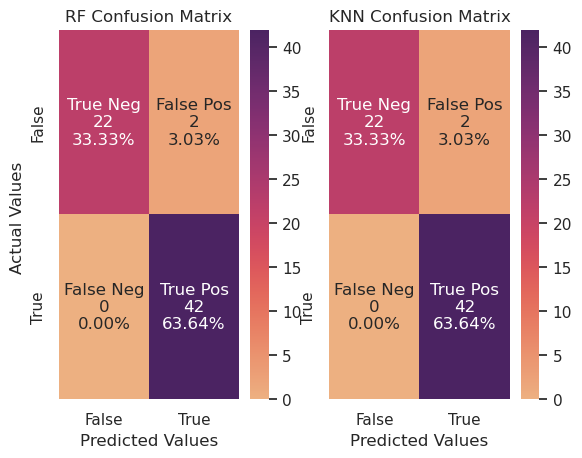

In [56]:
import numpy as np

#RF
rf_opt = rf_opt.fit(X_train, y_train)
rf_y_pred = rf_opt.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_y_pred)

group_names_rf = ['True Neg','False Pos','False Neg','True Pos']
group_counts_rf = ["{0:0.0f}".format(value) for value in
                rf_cm.flatten()]

group_percentages_rf = ["{0:.2%}".format(value) for value in
                     rf_cm.flatten()/np.sum(rf_cm)]

labels_rf = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_rf,group_counts_rf,group_percentages_rf)]

labels_rf = np.asarray(labels_rf).reshape(2,2)

#KNN
knn_opt = knn_opt.fit(X_train, y_train)
knn_y_pred = knn_opt.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_y_pred)

group_names_knn = ['True Neg','False Pos','False Neg','True Pos']
group_counts_knn = ["{0:0.0f}".format(value) for value in
                knn_cm.flatten()]

group_percentages_knn = ["{0:.2%}".format(value) for value in
                     knn_cm.flatten()/np.sum(knn_cm)]

labels_knn = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_knn,group_counts_knn,group_percentages_knn)]

labels_knn = np.asarray(labels_knn).reshape(2,2)

#plot
f, (ax_1, ax_2) = plt.subplots(1, 2)

ax1 = sns.heatmap(rf_cm, annot=labels_rf, fmt='', cmap='flare', ax=ax_1)


ax1.set_title('RF Confusion Matrix');
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(['False','True'])
ax1.yaxis.set_ticklabels(['False','True'])

ax2 = sns.heatmap(knn_cm, annot=labels_knn, fmt='', cmap='flare', ax=ax_2)

ax2.set_title('KNN Confusion Matrix');
ax2.set_xlabel('Predicted Values')
# ax2.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['False','True'])
ax2.yaxis.set_ticklabels(['False','True'])


plt.show()

Por último, **análise** das **matrizes de confusão** resultantes da previsão de cada um dos modelos revelam que ambos efetuam exatamente a **mesma classificação** das 66 amostras do test set, o que é condizente com os resultados atrás obtidos. Apenas ocorrerem **2 Falsos positivos** durante o processo de previsão.


### Sumário

No geral, a **comparação** entre os resultados provenientes da **validação cruzada** e **ML direto** indicaram-nos o potencial dos modelos ***Random Forest*** e ***KNN*** para efetuarem a correta **classificação** do dataset em estudo perante as **labels** fornecidas. Isto foi adiante confirmado pelos resultados da **otimização de hiperparâmetros** e por último pela **comparação dos modelos otimizados**. Deste modo, concluimos que para a construção de um modelo de ML para a correta classificação dos stresses como bióticos ou abióticos a partir dos dados de microarrais, **recomendamos os modelos KNN e Random Forest**. Mais concretamente, dentro dois dois recomendamos o modelo ***KNN***, por ser um modelo mais computacionalmente simples e rápido para os propósitos deste trabalho. Finalmente, os modelos prevêm muito bem para os dados fornecidos, não nos sendo possível contudo despistar um cenário de **overfitting** dado que não possuimos dados adicionais para efetuar testes. 

## Deep Learning

De forma a verificarmos se seria possível obter modelos mais robustos para a previsão de stress **abiótico** vs **biótico** a partir de dados de expressão genética de *Oryza Sativa*, efetuamos a construção de modelos de ***deep learning*** (**DL**) para este efeito. Na nossa abordagem testamos **3 tipologias** de modelos: ***deep neural network*** (**DNN**), ***long short term memory*** (**LSTM**) e ***convolutional neural network*** (**CNN**). Iremos apresentar seguidamente os resultados para cada uma destas abordagens.

As **camadas** usadas para construir os modelos foram decididas através de **experiências sucessivas**. Os resultados foram utilizados para **otimizar o performance** de cada um dos modelos de uma forma **manual**, dada a **impossibilidade computacional** de realizar uma **otimização de hiperparâmetros**.

De uma forma semelhante, esta mesma **metodologia** manual foi utilizada para a redução do ***overfitting***. A **colocação das camadas** ***dropout*** e dos parâmetros da metodologia ***Early Stopping***, que serão melhor explicados abaixo, foram determinados por **tentativa-erro**, chegando-se aos **resultados apresentados**.

A **turbulência das curvas de aprendizagem** apresenta-se **comum** aos 3 modelos testados, e **não reduziu** significativamente com o aumento do número de ***epochs***. No trabalho apresentado, mostramos os **melhores resultados** obtidos, que foram adquiridos com um **baixo número** de ***epochs***.

O tamanho do ***dataset*** de **validação** escolhido em todas as instâncias foi de **10%** do tamanho do ***dataset*** de **treino**. Este valor foi selecionado, após diversas tentativas, pois **não prejudica** significativamente o **treino do modelo**. Este valor, na prática, dá origem a um número de **entradas muito reduzido**, o que pode ajudar explicar a **irregularidade** das curvas de aprendizagem.

In [57]:
import keras.metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, GaussianNoise, Flatten, LSTM, Conv1D
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [58]:
"""
Re-importar dataset
"""

df = pd.read_csv("Final_ds.csv")

df["Stress"] = df["Stress"].replace({"Bio": 1, "Abio": 0})

X = df.iloc[:, 1:-1].values
y = df["Stress"].values

#Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

De forma a efetuar o **DL**, o dataset foi dividido num subconjunto de **treino** e **teste**, numa ratio de **7:3** respetivamente, à semelhança do efetuado em ML.

### Deep Neural Network

A **DNN** construída passa por uma camada ***dense*** **visível**, que recebe o nº total de *features* do dataset, e por 3 ***dense hidden layers*** que recebem **700**, **500** e **250** *features* respetivamente. AS camadas referidas usam como **função de ativação** ***rectified linear activation*** (**ReLU**). Por último é definida uma camada de ***output*** com **função de ativação sigmóide**. Dado o nosso problema ser um situação de **classificação binária**, na compilação do modelo foi parameterizada uma ***accuracy*** e ***loss*** **apropriada** para este problema, sendo usado o **algoritmo de treino** ***adam***.


De forma a **reduzir** o ***overfitting***, depois de cada camada foi definida uma camada ***Dropout***, em que o ***dropout rate** foi parameterizado a **20%**, significando que 1 em cada 5 inputs são aleatoriamente excluídos em cada ciclo. Foi também implementado uma metodologia de ***Early Stopping*** de forma a gerir o tempo de treino do modelo. A métrica monitorizada foi a ***loss*** do ***training set***, sendo que buscavamos **minimizar** o valor deste parâmetro. Se após **5** ***epochs*** não fosse obtido um valor mais baixo de loss, o treino do modelo é **interrompido**.

In [59]:
"""
Deep Neural Network (DNN)
"""

def dnn(x_train, y_train, x_test, y_test, input_size):
    model = Sequential()
    model.add(Dense(input_size, input_dim=input_size, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(700, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(250, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["binary_accuracy"])
    model.summary()
    es = EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=100, batch_size=1, verbose=1,
                        callbacks=[es])
    test_loss, test_acc = model.evaluate(x_test, y_test)

    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return model, test_loss, test_acc

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1377)              1897506   
_________________________________________________________________
dropout (Dropout)            (None, 1377)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 700)               964600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               350500    
__________________________________________

2025-08-19 16:26:47.104233: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2025-08-19 16:26:47.130612: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2112000000 Hz
2025-08-19 16:26:47.131437: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563a1cae0bb0 executing computations on platform Host. Devices:
2025-08-19 16:26:47.131456: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2025-08-19 16:26:47.162042: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not 

Epoch 1/100
137/137 [==============================] - 2s 13ms/sample - loss: 1.9161 - binary_accuracy: 0.6350 - val_loss: 5.5874 - val_binary_accuracy: 0.5625
Epoch 2/100
137/137 [==============================] - 2s 12ms/sample - loss: 2.5675 - binary_accuracy: 0.6715 - val_loss: 1.4436 - val_binary_accuracy: 0.7500
Epoch 3/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.4501 - binary_accuracy: 0.8102 - val_loss: 3.6235 - val_binary_accuracy: 0.6250
Epoch 4/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.2922 - binary_accuracy: 0.8467 - val_loss: 2.1394 - val_binary_accuracy: 0.8125
Epoch 5/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.4869 - binary_accuracy: 0.8540 - val_loss: 0.5965 - val_binary_accuracy: 0.8750
Epoch 6/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.3868 - binary_accuracy: 0.7737 - val_loss: 1.1707 - val_binary_accuracy: 0.8750
Epoch 7/100
137/137 [===================

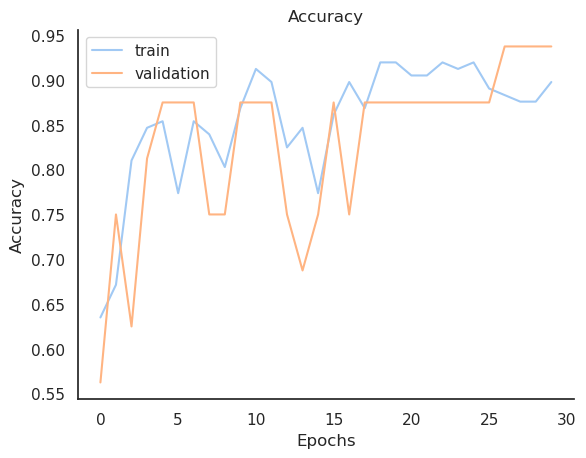

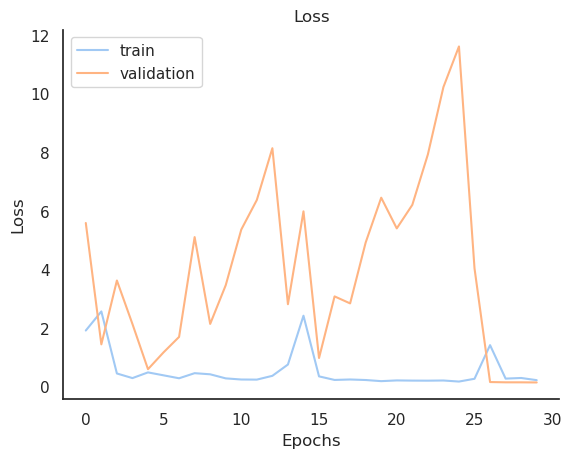

In [60]:
"""
Running the Model
"""
model, test_loss, test_acc = dnn(X_train, y_train, X_test, y_test, 1377)

In [61]:
"""
Printing accuracy and loss
"""

print(f"Test accuracy:' {test_acc}, loss: {test_loss}")

Test accuracy:' 0.8787878751754761, loss: 0.25929753346876666


No final do treino do modelo, observa-se que este treinou **21** ***epochs***, tendo uma ***accuracy*** de **~90%** e uma ***loss*** de **~25%**.

Observando os gráfico que repesenta a **evolução** da ***accuracy*** ao longo das ***epochs*** nos datasets de **treino** e **validação**, observamos uma **aumento exponencial** no caso do dataset de **treino**, tendo ainda muitas flutuações. No dataset de **validação**, obtém um **valor elevado inicial**, que sofre flutuações voltando-se a **aproximar** ao **valor inicial** de **~87%**.

Já no caso do gráfico de ***loss***, observamos uma **descida gradual** ao longo das ***epochs*** no caso do dataset de **treino**, mas uma **subida** no dataset de **validação**.

Pelos gráficos analisados, observamos que o nosso modelo apresenta **dificuldades no treino** devido às **oscilações** observadas na curva de ***accuracy*** do treino do modelo. Contudo, chamamos atenção para o **reduzido conjunto de dados** utilizado, e da fração minúscula de entradas ao dataset de validação, sendo necessários dados adicionais de forma a efetuar uma interpretação mais completa do treino do modelo.

### LSTM

A **LSTM** construída passa por uma camada **LSTM visível**, que recebe o nº total de *features* do dataset e é composto por **1000 neurónios**. Esta é precedida por **3** ***hidden layers*** que são compostas por **500**, **350** e **250 neurónios** respetivamente. Por último, a **camada** de ***output** é uma **camada** ***dense***. Tanto a **camada** de ***input*** como de ***output*** usam uma **função de ativação sigmóide**. O **uso recorrente de dados** foi **permitido** em todas as camadas LSTM. O **modelo** foi **compilado** usando **métricas binárias** e o **algoritmo de treino** ***adam***.

Como nas DNN, de forma a **combater** o ***overfitting*** foi adicionada uma **camada** ***Dropout*** depois da camada inicial e das *hidden layers* com uma taxa de ***dropout*** de **20%**. Foi também utlizado uma metodologia de ***Early Stopping***, tendo sido monitorizada a **minimização** da ***loss*** no modelo de treino, tendo sido atribuída uma ***patience*** de **5** ***epochs***.

O dataset de **validação** corresponde a **10%** do dataset de **treino**.

In [62]:

def lstm(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(-1, 1, 1377)
    x_test = x_test.reshape(-1, 1, 1377)
    y_train = y_train.reshape(-1, 1, )
    y_test = y_test.reshape(-1, 1, )
    model = Sequential()
    model.add(LSTM(units=1000, input_shape=(1, 1377), activation="sigmoid", return_sequences=True))
    model.add(Dropout(0.2)) #tecnica para prevenir overfitting
    model.add(LSTM(units=500, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=350, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=250, return_sequences=True))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["binary_accuracy"])
    model.summary()
    es = EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.1, batch_size=1, verbose=1, callbacks=[es])

    test_loss, test_acc = model.evaluate(x_test, y_test)

    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return model, test_loss, test_acc

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 1000)           9512000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1000)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 500)            3002000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 350)            1191400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 350)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 250)           

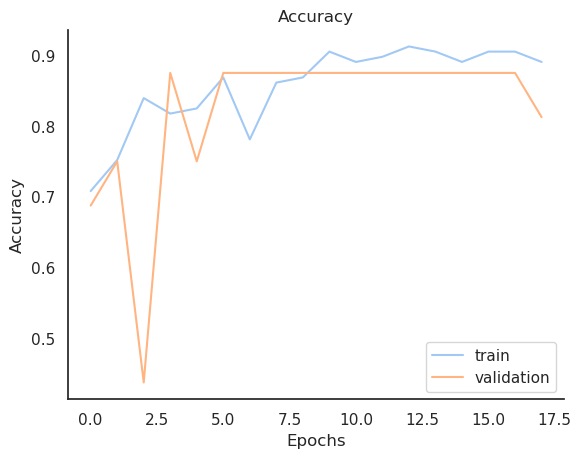

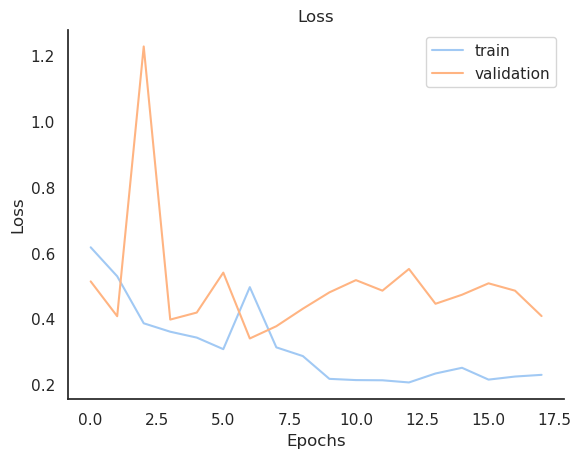

In [63]:
model, test_loss, test_acc = lstm(X_train, y_train, X_test, y_test)

In [64]:
print(f"Test accuracy:' {test_acc}, loss: {test_loss}")

Test accuracy:' 0.5964912176132202, loss: 1.3985877000924312


No final do treino do modelo, observa-se que este treinou **25** ***epochs***, tendo uma ***accuracy*** de **~90%** e uma ***loss*** de **~25%**.

Observando o gráfico que repesenta a **evolução** da ***accuracy*** ao longo das ***epochs*** nos datasets de **treino** e **validação**, observamos uma **aumento exponencial** no caso do dataset de **treino**, tendo ainda algumas flutuações. No dataset de **validação**, mantem-se **perto** do **valor inical** de **~87%**, observando-se apenas **algumas oscilações** para **valores inferiores** ao longo das ***epochs***.

Já no caso do gráfico de **loss**, observamos uma **descida gradual** ao longo das ***epochs*** no caso do dataset de **treino**, mas uma **subida** no dataset de **validação**.

Pelos gráficos analisados, observamos que o nosso modelo está a incorrer em ***overfitting*** com os dados do conjunto de **treino**. Contudo, chamamos atenção para o **reduzido conjunto de dados** utilizado, e da fração minúscula de entradas ao dataset de validação, sendo necessários dados adicionais de forma a efetuar uma interpretação mais completa do treino do modelo.

### CNN

A **CNN** construída inicia-se com uma normalização por ***Gaussian noise***, aplicando-se um **desvio padrão** de **0.05** da **distribuição** do **ruído**. Após definir as dimensões iniciais do modelo, a **camada inicial** é uma ***1D convolution layer*** (**Conv1D**), com ***filter*** de valor **8** e ***kernel size*** de **32**, **função de ativação ReLU** e um ***padding*** de ***same***, ou seja a camada irá acrescentar 0 ao *input* de forma a que o *output* tenha as mesmas dimensões que o *input*. De seguida é adicionada uma **Conv1D** **hidden layer**, parameterizada de forma semelhante ao anterior tendo um ***filter*** de **valor 16**. A função ***Flatten*** é usada para **transformar** a **matriz** vinda das camadas convolucionais num ***array***. De seguida acresentamos uma **camada** ***Dropout*** com um ***dropout rate*** de **20%** de forma a combater o ***overfitting***. A **última** ***hidden layer*** adicionada é uma **camada** ***Dense*** com **128** ***features*** e uma **função de ativação ReLU**. Por último, a **camada** de ***output*** corresponde a uma **camada** ***Dense*** com uma **função de ativação sigmoide**.

A **compilação** do **modelo** foi efetuada usando o **algoritmo de treino** ***adam*** e usando **métricas apropriadas** para **classificação binária**.

Para além disso, o ***Early Stopping*** também foi utilizado para **combater** o ***overfitting*** do modelo, tendo sido monitorizada a **minimização** da ***loss*** no modelo de **treino**, tendo sido atribuída uma ***patience*** de **5** ***epochs***.

O dataset de **validação** corresponde a **10%** do dataset de **treino**.

In [65]:
g_noise = 0.05

def cnn(x_train, y_train, x_test, y_test, input_dim,g_noise, C1_K=8, C1_S=32, C2_K=16, C2_S=32):
    model = Sequential()
    model.add(GaussianNoise(g_noise, input_shape=(input_dim,)))
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K,(C1_S), activation='relu', padding="same"))
    model.add(Conv1D(C2_K, (C2_S),  activation='relu', padding="same"))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    es = EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.1, batch_size=1, verbose=1, callbacks=[es])

    test_loss, test_acc = model.evaluate(x_test, y_test)

    # Plot Accuracy
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return cnn, test_loss, test_acc

Train on 137 samples, validate on 16 samples
Epoch 1/100
137/137 [==============================] - 2s 12ms/sample - loss: 0.5771 - binary_accuracy: 0.7153 - val_loss: 0.3603 - val_binary_accuracy: 0.8750
Epoch 2/100
137/137 [==============================] - 1s 9ms/sample - loss: 0.2521 - binary_accuracy: 0.8978 - val_loss: 1.2812 - val_binary_accuracy: 0.8125
Epoch 3/100
137/137 [==============================] - 1s 10ms/sample - loss: 0.2162 - binary_accuracy: 0.9124 - val_loss: 1.1069 - val_binary_accuracy: 0.8750
Epoch 4/100
137/137 [==============================] - 1s 10ms/sample - loss: 0.1853 - binary_accuracy: 0.9197 - val_loss: 1.9866 - val_binary_accuracy: 0.8750
Epoch 5/100
137/137 [==============================] - 1s 9ms/sample - loss: 0.2335 - binary_accuracy: 0.9051 - val_loss: 11.2782 - val_binary_accuracy: 0.3750
Epoch 6/100
137/137 [==============================] - 1s 9ms/sample - loss: 0.7616 - binary_accuracy: 0.8321 - val_loss: 0.3921 - val_binary_accuracy: 0.87

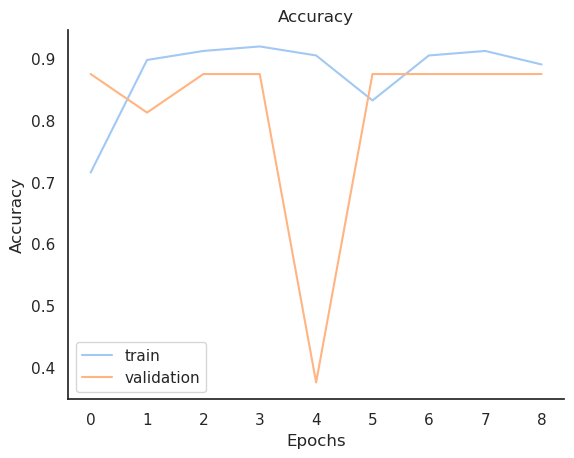

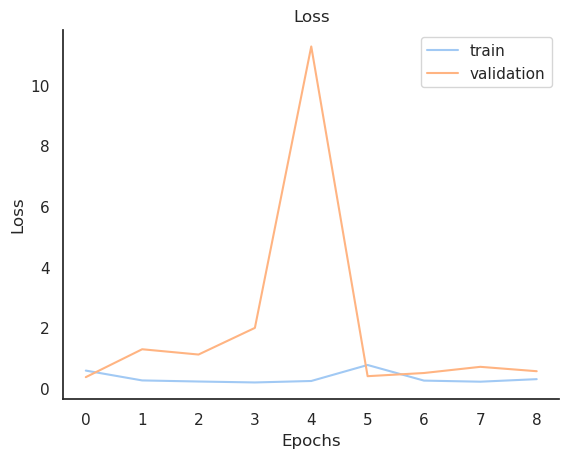

In [66]:
model, test_loss, test_acc = cnn(X_train, y_train, X_test, y_test, 1377, g_noise)

In [67]:
print(f"Test accuracy:' {test_acc}, loss: {test_loss}")

Test accuracy:' 0.8939393758773804, loss: 0.38864680673136853


No final do treino do modelo, observa-se que este treinou **17** ***epochs***, tendo uma ***accuracy*** de **~90%** e uma ***loss*** de **~24%**.

Observando o gráfico que repesenta a **evolução** da ***accuracy*** ao longo das ***epochs** nos datasets de **treino** e **validação**, observamos um **aumento exponêncial** no caso do dataset de **treino**. No dataset de **validação**, a ***accuarcy*** mantem-se **perto** do **valor inical** de **~87%**, observando-se apenas **uma oscilação** para **valores inferiores** ao longo das ***epochs***.

Já no caso do gráfico de ***loss***, observamos uma ligeira descida ao longo das ***epochs*** no caso do dataset de **treino**, mas uma **subida** no dataset de **validação**.

Pelos gráficos analisados, observamos que o nosso modelo está a incorrer em ***overfitting*** com os dados do conjunto de **treino**. Contudo, chamamos atenção para o **reduzido conjunto de dados** utilizado, e da fração minúscula de entradas ao dataset de validação, sendo necessários dados adicionais de forma a efetuar uma interpretação mais completa do treino do modelo.

### Sumário

A comparação entre as metodologias de **DL** aqui testadas (**DNN**, **LSTN** e **CNN**) revela que estas apresentam o **mesmo valor** de ***accuracy***, mas a que apresenta **menor** valor de ***loss*** é a **CNN**. Em **todos os cenários** a observação das **curvas de aprendizagem**, particularmente face à ***loss*** incorridda pelos modelos no processo de treino, revela-nos que em **todos ocorre** ***overfitting*** do **modelo de treino** face ao **modelo de validação**.

Esta informação **não pode ser dissociada da dimensionalidade do** ***dataset*** **utilizado**. Com **219 linhas**, as **subdivisões** aplicadas constituem ***datasets*** **muito reduzidos**, que não permitem uma avaliação da performance do modelo a larga escala. Uma **avaliação mais robusta** do modelo apenas seria **possível** utilizando um **conjunto de dados** com um **maior** número de entradas.

Na generalidade, o **uso** de modelos de **DL** parte de **conjuntos de dados** de uma **extensão considerável**. Desta forma **não podemos recomendar o uso** de modelos de **DL** para a concretização do objetivo deste trabalho, sendo para esse efeito necessário uma extensão dos dados disponíveis.

## Considerações finais

No decorrer deste trabalho foi possível extrair **dados de expressão genética** de ***Oryza Sativa***, a partir da **base de dados GEO**. Após um processo de curadoria, em que foram computadas as **médias entre réplicas**, foi obtido um ***dataset*** com **219 linhas**, e **1377 colunas**, que correspondem aos **genes previamente selecionados** por *Shaik & Ramakrishna, 2014*.

Com este dataset foi possível averiguar quais dos **genes** que melhor **separavam** as **classes biótica** e **abiótica**, tendo sido identificado **dois genes**, **Os.17449.1.A1_at** e **Os.14745.1.S1_at**, que se encontram **asscoiados** a **stresses abióticos** e **bióticos**, **respetivamente**.

De seguida, uma **análise de correlações** demonstrou a existência de **correlações fortes** entre os genes em estudo, quer **positivas** ou **negativas**, o que reflete as relações entre os **genes** que são expectáveis em dataset provenientes de **transcriptómica**.

A **redução de dimensionalidade** foi no geral bem sucedida, permitindo uma **visualização** do dataset a **2 dimensões** retendo cerca de **50%** da variabilidade do dataset. De todas as metodologias, aquela com melhores resultados no nosso estudo foi o **PCA**, permitindo uma **distinção visual clara** entre as classes em estudo no mapa fatorial.

Os resultados do **clustering**, quer ***K-Means*** quer **Clustering Hierárquico**, apresentam atribuições **iguais** das linhas aos grupos. No caso do **clustering hierárquico** podemos observar ainda o **dendograma** que nos fornece informações do comportamento do algoritmo face ao dataset em dimensões mais elevadas.

Já na **análise supervisionada**, temos que da análise **ML** resultaram **dois modelos** com a mesma performance face ao objetivo do trabalho: ***Random Forest*** e **KNN** com uma ***accuracy*** de **97%**. Desta forma é dada preferência ao modelo **KNN** pela sua reduzida complexidade.

Seguidamente foi implementado **DL** sobre o dataset, sendo que cada uma das abordagens testadas apresentava **problemas** de ***overfitting*** quando analisadas as suas curvas de aprendizagem. O melhor modelo foi o de **CNN** apresentando uma ***accuracy*** de **89%**. Os valores reduzidos de accuracy em **DL** face a **ML** podem ser parcialmente explicados pelo **ruído inerente a dados transcriptómicos**, o que os tornam de **difícil interpretação** pelos modelos usados nesta metedologia.

## Conclusão

Dado o objetivo do estudo em questão, a identificação de um **modelo de ML** capaz de efetuar a previsão da **ocorrência de stress biótico** ***vs*** **abiótico** a partir de dados de **transcriptómica** provenientes de ***microarrays***, temos que o modelo **recomendado** para este efeito, tendo em conta os nossos resultados, é o modelo **KNN**, devido a sua **elevada** ***accuracy*** e a sua relativa **simplicidade computacional**. As abordagens de **DL** apenas se **tornam viáveis** a partir de um **elevado conjunto de dados iniciais**, que de momento **não existe**. Desta forma **recomendamos** um **maior volume** de geração e disponibilização de **dados de transcriptómica** em ***Oriza Sativa***, de forma a ser possível construir modelos mais robustos no futuro.